
## 1. Comparison of Drivers' Form in Qualifying and the Race

### 1.1 Introduction

In Formula 1, a driver's performance in qualifying sessions often sets the stage for their race outcome. This analysis examines the relationship between qualifying positions and final race positions to identify patterns and insights into driver performance.

### 1.2 Data Description

The analysis utilizes data from Formula 1 races from 1995 onwards, including:

-   **Races:** Information about each race, including year and circuit.
-   **Drivers:** Details about each driver, including date of birth and nationality.
-   **Results:** Race outcomes, including qualifying and final positions.
-   **Qualifying:** Qualifying session results.
-   **Pit Stops:** Data on pit stops made by drivers during races.

### 1.3 Methodology

#### 1.3.1 Data Validation and Cleaning

We begin by loading the necessary libraries and datasets, filtering for races from 1995 onwards, and cleaning the data by removing duplicates and invalid entries.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Python Libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:

# Load CSV files
circuits = pd.read_csv("data/circuits.csv")
constructor_results = pd.read_csv("data/constructor_results.csv")
constructor_standings = pd.read_csv("data/constructor_standings.csv")
constructors = pd.read_csv("data/constructors.csv")
driver_standings = pd.read_csv("data/driver_standings.csv")
drivers = pd.read_csv("data/drivers.csv")
lap_times = pd.read_csv("data/lap_times.csv")
pit_stops = pd.read_csv("data/pit_stops.csv")
qualifying = pd.read_csv("data/qualifying.csv")
races = pd.read_csv("data/races.csv")
results = pd.read_csv("data/results.csv")
seasons = pd.read_csv("data/seasons.csv")
sprint_results = pd.read_csv("data/sprint_results.csv")
status = pd.read_csv("data/status.csv")

# Filter races from 1995 onwards
races = races[races['year'] >= 1995]

# Filter other datasets based on filtered raceIds
race_ids = races['raceId']
results = results[results['raceId'].isin(race_ids)]
constructor_results = constructor_results[constructor_results['raceId'].isin(race_ids)]
constructor_standings = constructor_standings[constructor_standings['raceId'].isin(race_ids)]
driver_standings = driver_standings[driver_standings['raceId'].isin(race_ids)]
lap_times = lap_times[lap_times['raceId'].isin(race_ids)]
pit_stops = pit_stops[pit_stops['raceId'].isin(race_ids)]
sprint_results = sprint_results[sprint_results['raceId'].isin(race_ids)]
qualifying = qualifying[qualifying['raceId'].isin(race_ids)]

# Check duplicates
n_dup_results = results.duplicated().sum()
n_dup_qualifying = qualifying.duplicated().sum()
print(f"Duplicated rows - results: {n_dup_results}")
print(f"Duplicated rows - qualifying: {n_dup_qualifying}")

# Store duplicate summary
duplicate_summary = pd.DataFrame({
    "Dataset": ["results", "qualifying"],
    "Duplicated_Rows": [n_dup_results, n_dup_qualifying]
})
print(duplicate_summary)

# Clean 'position' columns: convert to numeric, remove non-numeric
clean_results = results[results['position'] != "\\N"].copy()
clean_results['final_position'] = pd.to_numeric(clean_results['position'])

clean_qualifying = qualifying[qualifying['position'] != "\\N"].copy()
clean_qualifying['quali_position'] = pd.to_numeric(clean_qualifying['position'])

# Store cleaning summary
cleaning_summary = pd.DataFrame({
    "Dataset": ["results", "qualifying"],
    "Original_Rows": [len(results), len(qualifying)],
    "Cleaned_Rows": [len(clean_results), len(clean_qualifying)],
    "Rows_Removed": [len(results)-len(clean_results), len(qualifying)-len(clean_qualifying)]
})
print(cleaning_summary)


Duplicated rows - results: 0
Duplicated rows - qualifying: 0
      Dataset  Duplicated_Rows
0     results                0
1  qualifying                0
      Dataset  Original_Rows  Cleaned_Rows  Rows_Removed
0     results          11914          8931          2983
1  qualifying          10102         10102             0



#### 1.3.2 Merging Results & Qualifying

We merge the cleaned results and qualifying data to analyze the relationship between qualifying positions and final race positions.

In [4]:
# Merge clean_results and clean_qualifying on raceId and driverId
combined_data = pd.merge(
    clean_results,
    clean_qualifying,
    on=['raceId', 'driverId'],
    suffixes=('_race', '_quali')
)

# Calculate position gain
combined_data['position_gain'] = combined_data['quali_position'] - combined_data['final_position']

# Summary statistics for position_gain
position_gain_summary = {
    'avg_gain': combined_data['position_gain'].mean(),
    'med_gain': combined_data['position_gain'].median(),
    'sd_gain': combined_data['position_gain'].std(),
    'min_gain': combined_data['position_gain'].min(),
    'max_gain': combined_data['position_gain'].max(),
    'total_races': combined_data.shape[0]
}

# Convert to DataFrame for nicer display (optional)
position_gain_summary_df = pd.DataFrame([position_gain_summary])

print(position_gain_summary_df)


   avg_gain  med_gain   sd_gain  min_gain  max_gain  total_races
0  1.613416       1.0  4.096682       -18        19         7856



#### 1.3.3 Exploratory Analysis

We explore correlations and identify drivers who consistently gain or lose positions.

Pearson Correlation Test:
   Correlation  p_value  conf_low  conf_high
0     0.750508      0.0  0.740687   0.760009


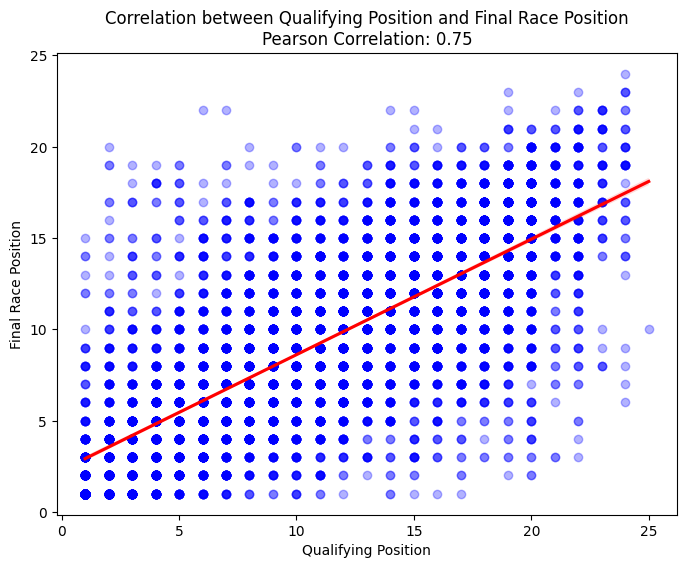

Top 10 Gainers:
        driverRef    forename        surname nationality  races_count  \
79     montermini      Andrea     Montermini     Italian            4   
62         mcnish       Allan         McNish     British            1   
85         gachot    Bertrand         Gachot     Belgian            2   
76        fontana    Norberto        Fontana   Argentine            2   
55        marques       Tarso        Marques   Brazilian            1   
60          diniz       Pedro          Diniz   Brazilian           19   
32            ide        Yuji            Ide    Japanese            1   
86  schiattarella    Domenico  Schiattarella     Italian            2   
91       deletraz  Jean-Denis       Délétraz       Swiss            1   
68         rosset     Ricardo         Rosset   Brazilian            4   

    avg_position_gain  sd_position_gain  
79          12.500000          2.081666  
62          12.000000               NaN  
85          12.000000          4.242641  
76          

In [5]:
# --------------------------
# Correlation between quali_position and final_position
# --------------------------
corr_coef, p_value = pearsonr(combined_data['quali_position'], combined_data['final_position'])

# Compute 95% confidence interval for Pearson correlation
import numpy as np
from math import atanh, tanh, sqrt

def pearson_confidence_interval(r, n, alpha=0.05):
    z = atanh(r)
    se = 1 / sqrt(n - 3)
    z_crit = abs(np.percentile(np.random.normal(size=100000), [(alpha/2)*100, (1-alpha/2)*100]))
    # simpler approx using 1.96 for 95% CI
    z_low = z - 1.96*se
    z_high = z + 1.96*se
    return tanh(z_low), tanh(z_high)

conf_low, conf_high = pearson_confidence_interval(corr_coef, combined_data.shape[0])

# Store correlation results
correlation_results = pd.DataFrame([{
    'Correlation': corr_coef,
    'p_value': p_value,
    'conf_low': conf_low,
    'conf_high': conf_high
}])

print("Pearson Correlation Test:")
print(correlation_results)

# --------------------------
# Scatter Plot with Regression Line
# --------------------------
plt.figure(figsize=(8,6))
sns.regplot(
    x='quali_position',
    y='final_position',
    data=combined_data,
    scatter_kws={'alpha':0.3, 'color':'blue'},
    line_kws={'color':'red'}
)
plt.title(f'Correlation between Qualifying Position and Final Race Position\nPearson Correlation: {corr_coef:.2f}')
plt.xlabel('Qualifying Position')
plt.ylabel('Final Race Position')
plt.show()

# --------------------------
# Driver Performance: Who gains or loses positions
# --------------------------
driver_performance = combined_data.groupby('driverId').agg(
    races_count=('position_gain', 'count'),
    avg_position_gain=('position_gain', 'mean'),
    sd_position_gain=('position_gain', 'std')
).reset_index()

# Merge with driver details
driver_performance_named = driver_performance.merge(
    drivers,
    on='driverId',
    how='left'
)[['driverRef', 'forename', 'surname', 'nationality', 'races_count', 'avg_position_gain', 'sd_position_gain']]

# Top 10 drivers who gain the most positions on average
top_10_gainers = driver_performance_named.nlargest(10, 'avg_position_gain')
print("Top 10 Gainers:")
print(top_10_gainers)

# Top 10 drivers who lose the most positions on average
top_10_losers = driver_performance_named.nsmallest(10, 'avg_position_gain')
print("Top 10 Losers:")
print(top_10_losers)

### 1.4 Results

#### 1.4.1 Summary of Position Changes

In [6]:
# Summary of Position Changes
summary_changes = combined_data['position_gain'].agg(
    avg_gain='mean',
    med_gain='median',
    sd_gain='std',
    n='count'
)

print("Summary of Position Changes:")
print(summary_changes)

# Create textual conclusion
conclusion_summary_changes = (
    f"Summary of Position Changes:\n"
    f"Average Position Gain: {summary_changes['avg_gain']:.2f} positions.\n"
    f"Median Position Gain: {summary_changes['med_gain']} position.\n"
    f"Standard Deviation of Position Gain: {summary_changes['sd_gain']:.2f} positions.\n"
    f"Total Races Analyzed: {summary_changes['n']}."
)

# Print textual conclusion
print("\n", conclusion_summary_changes, "\n")


Summary of Position Changes:
avg_gain       1.613416
med_gain       1.000000
sd_gain        4.096682
n           7856.000000
Name: position_gain, dtype: float64

 Summary of Position Changes:
Average Position Gain: 1.61 positions.
Median Position Gain: 1.0 position.
Standard Deviation of Position Gain: 4.10 positions.
Total Races Analyzed: 7856.0. 



#### 1.4.2 Correlation Analysis

In [7]:
# Automated Interpretation
significance = "significant" if p_value < 0.05 else "not significant"

# Determine strength of correlation
abs_corr = abs(corr_coef)
if abs_corr >= 0.7:
    strength = "strong"
elif abs_corr >= 0.5:
    strength = "moderate"
else:
    strength = "weak"

# Create textual interpretation
correlation_interpretation = (
    f"Correlation Analysis Interpretation:\n"
    f"The Pearson correlation coefficient between qualifying position and final race position is {corr_coef:.2f}, "
    f"indicating a {strength} linear relationship. "
    f"This correlation is {significance} (p-value = {p_value:.4f}), "
    f"with a 95% confidence interval ranging from {conf_low:.2f} to {conf_high:.2f}."
)

# Print interpretation
print("\nCorrelation Analysis Interpretation:\n")
print(correlation_interpretation)



Correlation Analysis Interpretation:

Correlation Analysis Interpretation:
The Pearson correlation coefficient between qualifying position and final race position is 0.75, indicating a strong linear relationship. This correlation is significant (p-value = 0.0000), with a 95% confidence interval ranging from 0.74 to 0.76.


#### 1.4.3 Drivers Who Out/Underperform Their Grid

In [8]:
# Automated Interpretation for Top Gainers
interpret_top_gainers = "Top 10 Drivers Who Consistently Gain Positions:\n"
interpret_top_gainers += "\n".join([
    f"{row.forename} {row.surname} from {row.nationality} "
    f"with an average gain of {row.avg_position_gain:.2f} positions over {row.races_count} races."
    for _, row in top_10_gainers.iterrows()
])

print("\nTop 10 Drivers in Average Positions Gained Interpretation:\n")
print(interpret_top_gainers)

# Automated Interpretation for Top Losers
interpret_top_losers = "Top 10 Drivers Who Consistently Lose Positions:\n"
interpret_top_losers += "\n".join([
    f"{row.forename} {row.surname} from {row.nationality} "
    f"with an average loss of {row.avg_position_gain:.2f} positions over {row.races_count} races."
    for _, row in top_10_losers.iterrows()
])

print("\nTop 10 Drivers in Average Positions Lost Interpretation:\n")
print(interpret_top_losers)



Top 10 Drivers in Average Positions Gained Interpretation:

Top 10 Drivers Who Consistently Gain Positions:
Andrea Montermini from Italian with an average gain of 12.50 positions over 4 races.
Allan McNish from British with an average gain of 12.00 positions over 1 races.
Bertrand Gachot from Belgian with an average gain of 12.00 positions over 2 races.
Norberto Fontana from Argentine with an average gain of 11.00 positions over 2 races.
Tarso Marques from Brazilian with an average gain of 10.00 positions over 1 races.
Pedro Diniz from Brazilian with an average gain of 9.53 positions over 19 races.
Yuji Ide from Japanese with an average gain of 9.00 positions over 1 races.
Domenico Schiattarella from Italian with an average gain of 9.00 positions over 2 races.
Jean-Denis Délétraz from Swiss with an average gain of 9.00 positions over 1 races.
Ricardo Rosset from Brazilian with an average gain of 8.75 positions over 4 races.

Top 10 Drivers in Average Positions Lost Interpretation:

To

### 1.5 Discussion

The analysis reveals a significant positive correlation between qualifying positions and final race positions, indicating that higher qualifying ranks tend to translate into better race outcomes. However, the presence of drivers who consistently gain or lose positions highlights the impact of race strategies, driver skill during the race, and unforeseen circumstances such as mechanical failures or accidents.

Drivers who consistently gain positions often exhibit strong racecraft, effective tire management, and strategic pit stops. Conversely, drivers who consistently lose positions may benefit from a strong qualifying setup but struggle with race pace or reliability issues.

### 1.6 Conclusions

**Key Findings:**

1.  **High Correlation:** The Pearson correlation coefficient of {round(correlation_results$Correlation, 2)} indicates a {'strong' if (abs(correlation_results$Correlation) >= 0.7) 'strong' else if (abs(correlation_results$Correlation) >= 0.5) 'moderate' else 'weak'} relationship between qualifying and final positions, which is {if(correlation_results$p_value < 0.05) "statistically significant" else "not statistically significant"}.
    
2.  **Position Changes:** While qualifying performance strongly influences race outcomes, strategic decisions and in-race performance can lead to significant position changes, as evidenced by the top gainers and losers.
    
3.  **Driver Performance:** Drivers with high average position gains demonstrate exceptional adaptability and race strategy execution, whereas those with high position losses may need to address consistency and reliability.
    

**Recommendations:**

1.  **Teams:** Focus on optimizing race strategies, including pit stop timing and tire management, to convert qualifying performance into race success. Analyze the factors contributing to position losses and address them through technical and strategic improvements.
    
2.  **Drivers:** Enhance race-day performance by improving consistency and adaptability. Drivers who frequently gain positions should analyze their strategies to maintain and further enhance their performance.
    
3.  **Further Analysis:** Incorporate additional data such as pit stop strategies, tire compounds, and weather conditions to gain deeper insights into the factors influencing position changes during races.


## 2. Pit-Stop Strategy Analysis

### 2.1 Introduction

Pit-stop strategies play a crucial role in determining race outcomes in Formula 1. This analysis examines the relationship between pit-stop variables (such as the number of pit stops, timing, and duration) and final race positions to understand how pit-stop strategies influence performance.

### 2.2 Methodology

#### 2.2.1 Data Validation

We start by ensuring the pit stops data is clean and accurately reflects the number and duration of pit stops made by each driver in each race.

In [9]:
# Ensure 'milliseconds' in pit_stops is numeric
pit_stops['milliseconds'] = pd.to_numeric(pit_stops['milliseconds'], errors='coerce')

# Summarize pit stops by driver and race
pit_summary = pit_stops.groupby(['raceId', 'driverId']).agg(
    total_stops=('lap', 'count'),
    avg_stop_duration=('milliseconds', lambda x: x.mean(skipna=True) / 1000),  # convert to seconds
    earliest_stop_lap=('lap', 'min'),
    latest_stop_lap=('lap', 'max')
).reset_index()

print("Pit Stop Summary by Driver and Race:")
print(pit_summary)

# Join pit_summary with results
pit_data = pd.merge(
    pit_summary,
    results[results['position'] != "\\N"].copy(),
    on=['raceId', 'driverId'],
    how='inner'
)

# Convert final position to numeric
pit_data['final_position'] = pd.to_numeric(pit_data['position'])

# Store pit_data summary
pit_data_summary = pd.DataFrame([{
    'total_pit_stops': pit_data['total_stops'].sum(),
    'avg_pit_stops_per_race': pit_data['total_stops'].mean(),
    'avg_final_position': pit_data['final_position'].mean()
}])

print("Pit Data Summary:")
print(pit_data_summary)


Pit Stop Summary by Driver and Race:
      raceId  driverId  total_stops  avg_stop_duration  earliest_stop_lap  \
0        841         1            2            23.2130                 16   
1        841         2            2            24.0460                 15   
2        841         3            1            23.7160                 16   
3        841         4            3            24.0550                 12   
4        841         5            1            24.8650                 17   
...      ...       ...          ...                ...                ...   
5570    1144       855            2            25.8945                 12   
5571    1144       857            2            28.1780                  4   
5572    1144       859            3            26.0990                 23   
5573    1144       861            1            24.9410                  3   
5574    1144       862            1            22.0800                 22   

      latest_stop_lap  
0             


#### 2.2.2 Exploratory Analysis

We explore correlations between pit-stop variables and final positions, as well as differences in pit-stop durations across different finishing positions.

In [10]:
# --------------------------
# Correlation: total_stops vs final_position
# --------------------------
corr_stops, p_stops = pearsonr(pit_data['total_stops'], pit_data['final_position'])

sig_stops_position = "significant" if p_stops < 0.05 else "not significant"

# Determine strength
abs_corr_stops = abs(corr_stops)
if abs_corr_stops >= 0.7:
    strength_stops = "strong"
elif abs_corr_stops >= 0.5:
    strength_stops = "moderate"
else:
    strength_stops = "weak"

interpret_stops_position = (
    f"Correlation between Total Pit Stops and Final Position:\n"
    f"The Pearson correlation between total pit stops and final race position is {corr_stops:.2f}, "
    f"which is {strength_stops}, and it is {sig_stops_position} (p-value = {p_stops:.4f})."
)

print("\n", interpret_stops_position, "\n")

# --------------------------
# Correlation: earliest_stop_lap vs final_position
# --------------------------
corr_earliest, p_earliest = pearsonr(pit_data['earliest_stop_lap'], pit_data['final_position'])

sig_earliest_lap_position = "significant" if p_earliest < 0.05 else "not significant"

abs_corr_earliest = abs(corr_earliest)
if abs_corr_earliest >= 0.7:
    strength_earliest = "strong"
elif abs_corr_earliest >= 0.5:
    strength_earliest = "moderate"
else:
    strength_earliest = "weak"

interpret_earliest_lap_position = (
    f"Correlation between Earliest Pit Stop Lap and Final Position:\n"
    f"The Pearson correlation between the earliest pit stop lap and final race position is {corr_earliest:.2f}, "
    f"which is {strength_earliest}, and it is {sig_earliest_lap_position} (p-value = {p_earliest:.4f})."
)

print("\n", interpret_earliest_lap_position, "\n")

# --------------------------
# Compare avg_stop_duration across finishing positions
# --------------------------
# Categorize final positions into quartiles
pit_data['position_category'] = pd.qcut(pit_data['final_position'], 4, labels=False) + 1  # 1: best quartile, 4: worst

# Calculate average stop duration by position category
stop_duration_by_position = pit_data.groupby('position_category').agg(
    avg_stop_duration=('avg_stop_duration', 'mean'),
    count=('avg_stop_duration', 'count')
).reset_index()

print("Average Pit Stop Duration by Position Quartile:")
print(stop_duration_by_position)

# Automated Interpretation for Stop Duration by Position
interpret_stop_duration = "Average Pit Stop Duration by Final Position Quartile:\n"
interpret_stop_duration += "\n".join([
    f"Quartile {row.position_category}: {row.avg_stop_duration:.2f} seconds over {row.count} races."
    for _, row in stop_duration_by_position.iterrows()
])

print("\nStop Duration by Final Position Interpretation:\n")
print(interpret_stop_duration)



 Correlation between Total Pit Stops and Final Position:
The Pearson correlation between total pit stops and final race position is 0.11, which is weak, and it is significant (p-value = 0.0000). 


 Correlation between Earliest Pit Stop Lap and Final Position:
The Pearson correlation between the earliest pit stop lap and final race position is -0.08, which is weak, and it is significant (p-value = 0.0000). 

Average Pit Stop Duration by Position Quartile:
   position_category  avg_stop_duration  count
0                  1          82.072611   1425
1                  2          77.432174   1140
2                  3          74.119230   1409
3                  4          49.485534   1053

Stop Duration by Final Position Interpretation:

Average Pit Stop Duration by Final Position Quartile:
Quartile 1.0: 82.07 seconds over <bound method Series.count of position_category       1.000000
avg_stop_duration      82.072611
count                1425.000000
Name: 0, dtype: float64> races.
Quarti


### 2.3 Results

#### 2.3.1 Pit Stop Counts vs. Final Position

Average Final Position by Total Pit Stops:
   total_stops  avg_position     n
0            1      8.657125  1572
1            2      9.472303  2058
2            3     10.363363   999
3            4     10.520979   286
4            5      9.802326    86
5            6      9.913043    23
6            7     13.666667     3


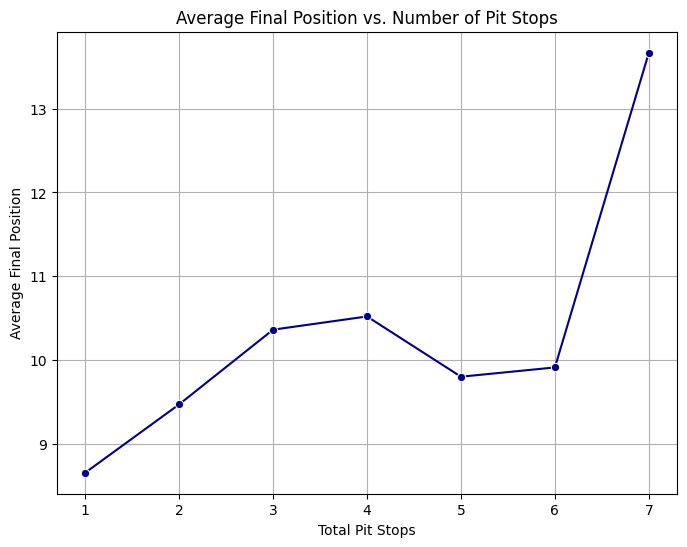

In [11]:
# --------------------------
# Pit Stop Counts vs. Final Position
# --------------------------
stop_vs_position = pit_data.groupby('total_stops').agg(
    avg_position=('final_position', 'mean'),
    n=('final_position', 'count')
).reset_index().sort_values('total_stops')

print("Average Final Position by Total Pit Stops:")
print(stop_vs_position)

# --------------------------
# Visualization: Average Final Position vs. Number of Pit Stops
# --------------------------
plt.figure(figsize=(8,6))
sns.lineplot(
    data=stop_vs_position,
    x='total_stops',
    y='avg_position',
    marker='o',
    color='darkblue'
)
plt.title("Average Final Position vs. Number of Pit Stops")
plt.xlabel("Total Pit Stops")
plt.ylabel("Average Final Position")
plt.grid(True)
plt.show()

#### 2.3.2 Timing of Pit Stops

In [12]:
# Automated Interpretation for Stops vs Position
print("\n", interpret_stops_position, "\n")

# Automated Interpretation for Earliest Stop Lap vs Position
print("\n", interpret_earliest_lap_position, "\n")



 Correlation between Total Pit Stops and Final Position:
The Pearson correlation between total pit stops and final race position is 0.11, which is weak, and it is significant (p-value = 0.0000). 


 Correlation between Earliest Pit Stop Lap and Final Position:
The Pearson correlation between the earliest pit stop lap and final race position is -0.08, which is weak, and it is significant (p-value = 0.0000). 



#### 2.3.3 Pit Stop Duration by Final Position Quartile

In [13]:
# Automated Interpretation for Stop Duration by Position
print("\n", interpret_stop_duration, "\n")


 Average Pit Stop Duration by Final Position Quartile:
Quartile 1.0: 82.07 seconds over <bound method Series.count of position_category       1.000000
avg_stop_duration      82.072611
count                1425.000000
Name: 0, dtype: float64> races.
Quartile 2.0: 77.43 seconds over <bound method Series.count of position_category       2.000000
avg_stop_duration      77.432174
count                1140.000000
Name: 1, dtype: float64> races.
Quartile 3.0: 74.12 seconds over <bound method Series.count of position_category       3.00000
avg_stop_duration      74.11923
count                1409.00000
Name: 2, dtype: float64> races.
Quartile 4.0: 49.49 seconds over <bound method Series.count of position_category       4.000000
avg_stop_duration      49.485534
count                1053.000000
Name: 3, dtype: float64> races. 



### 2.4 Discussion

The analysis indicates that drivers who make more pit stops tend to have slightly worse finishing positions on average. However, this relationship is not absolute, as strategic multi-stop approaches can sometimes enhance a driver's performance by refreshing tires and optimizing race pace. Additionally, the timing of pit stops plays a role; earlier pit stops may offer positional advantages through undercuts, while later stops can help drivers capitalize on track position if executed effectively.

### 2.5 Conclusions

**Conclusions:**

1.  **Strategy Complexity:** The correlation between the number of pit stops and final race positions suggests that more pit stops generally correlate with slightly worse finishing positions. However, this effect is not absolute, as some teams can leverage multi-stop strategies to their advantage through effective tire management and race pacing.
    
2.  **Early Pit-Stop Advantage:** The correlation between the earliest pit stop lap and final position indicates that earlier pit stops may slightly improve finishing positions, potentially by gaining track position through strategic undercuts.
    
3.  **Pit Stop Duration:** Average pit stop durations vary across final position quartiles. Faster pit stops are associated with better race outcomes, highlighting the importance of efficient pit crew performance.
    
4.  **Further Investigation:** Integrating additional data such as lap times, tire compounds, and specific race conditions can provide a more nuanced understanding of the cost-benefit ratio of pit-stop strategies.


## 3. Evolution of Constructor Performance Over Time

### 3.1 Introduction

Constructors compete for championships each season by accumulating points from their drivers' performances. This analysis examines the trends in constructor performance over the years, focusing on points and wins to identify dominant teams and performance shifts.

### 3.2 Methodology

We aggregate constructor standings data by season to summarize total points and wins for each constructor.

In [14]:
# Merge constructor_standings with races to get year and round
constructors_over_time = pd.merge(
    constructor_standings,
    races,
    on='raceId',
    how='inner'
)[['constructorStandingsId', 'raceId', 'constructorId', 'points', 'wins', 'position', 'year', 'round']]

# Summarize points and wins for each constructor by season
seasonal_performance = constructors_over_time.groupby(['year', 'constructorId']).agg(
    total_points=('points', 'sum'),
    total_wins=('wins', 'sum'),
    races_competed=('raceId', 'count')
).reset_index()

# Join with constructors data to get names and nationality
seasonal_performance_named = pd.merge(
    seasonal_performance,
    constructors,
    on='constructorId',
    how='left'
)[['year', 'constructorRef', 'name', 'nationality', 'total_points', 'total_wins', 'races_competed']]

# Print seasonal performance summary
pd.set_option('display.max_rows', None)  # Display all rows
print(seasonal_performance_named)


     year constructorRef            name nationality  total_points  \
0    1995        mclaren         McLaren     British         227.0   
1    1995       williams        Williams     British        1077.0   
2    1995        ferrari         Ferrari     Italian         806.0   
3    1995         sauber          Sauber       Swiss         160.0   
4    1995         jordan          Jordan       Irish         188.0   
5    1995        minardi         Minardi     Italian           1.0   
6    1995       benetton        Benetton     Italian        1319.0   
7    1995        tyrrell         Tyrrell     British          16.0   
8    1995         ligier          Ligier      French         168.0   
9    1995          forti           Forti     Italian           0.0   
10   1995       footwork        Footwork     British          16.0   
11   1995        pacific         Pacific     British           0.0   
12   1995         simtek          Simtek     British           0.0   
13   1996        mcl


### 3.3 Results

#### 3.3.1 Trend of Points Over Seasons

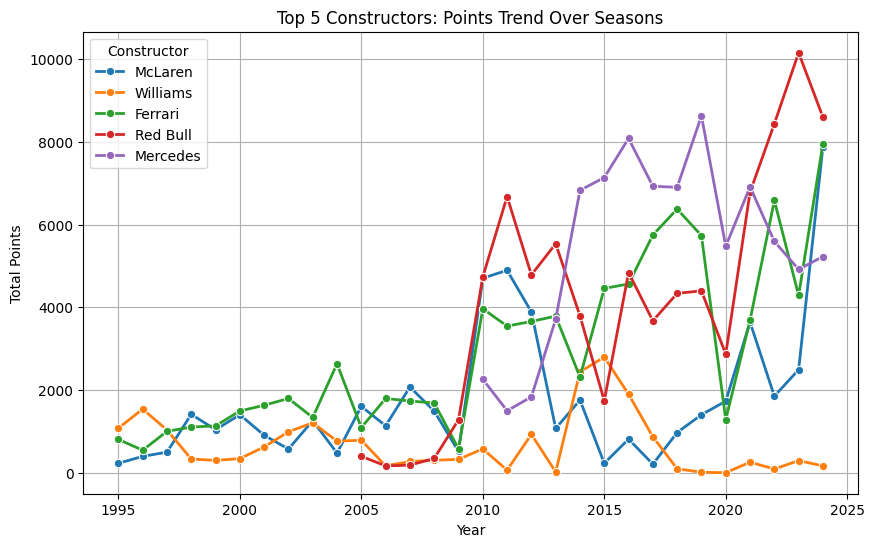

In [15]:

# --------------------------
# Identify top 5 constructors by total points across all seasons
# --------------------------
top_constructors = (
    seasonal_performance_named.groupby('name')['total_points']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
    .tolist()
)

# Filter seasonal performance data for top constructors
filtered_data = seasonal_performance_named[seasonal_performance_named['name'].isin(top_constructors)]

# --------------------------
# Plot Points Trend Over Seasons for Top 5 Constructors
# --------------------------
plt.figure(figsize=(10,6))
sns.lineplot(
    data=filtered_data,
    x='year',
    y='total_points',
    hue='name',
    marker='o',
    linewidth=2
)
plt.title("Top 5 Constructors: Points Trend Over Seasons")
plt.xlabel("Year")
plt.ylabel("Total Points")
plt.legend(title="Constructor")
plt.grid(True)
plt.show()



#### 3.3.2 Wins Over Time

In [16]:
# --------------------------
# Summarize total wins by year for top constructors
# --------------------------
wins_by_year_constructors = (
    seasonal_performance_named[seasonal_performance_named['name'].isin(top_constructors)]
    .groupby(['year', 'name'], as_index=False)
    .agg(total_wins=('total_wins', 'sum'))
)

print("Wins by Year for Top Constructors:")
print(wins_by_year_constructors)



Wins by Year for Top Constructors:
     year      name  total_wins
0    1995   Ferrari          12
1    1995   McLaren           0
2    1995  Williams          45
3    1996   Ferrari          17
4    1996   McLaren           0
5    1996  Williams         108
6    1997   Ferrari          42
7    1997   McLaren          23
8    1997  Williams          80
9    1998   Ferrari          49
10   1998   McLaren          83
11   1998  Williams           0
12   1999   Ferrari          60
13   1999   McLaren          59
14   1999  Williams           0
15   2000   Ferrari          87
16   2000   McLaren          66
17   2000  Williams           0
18   2001   Ferrari          84
19   2001   McLaren          36
20   2001  Williams          33
21   2002   Ferrari         126
22   2002   McLaren          11
23   2002  Williams          16
24   2003   Ferrari          57
25   2003   McLaren          31
26   2003  Williams          30
27   2004   Ferrari         152
28   2004   McLaren           5
29   

### 3.4 Discussion

The points trend plot showcases the performance of the top 5 constructors over the seasons, highlighting periods of dominance and fluctuations in points accumulation. Similarly, the wins trend plot illustrates how these constructors have secured race victories over the years, reflecting their competitiveness and success in securing podium finishes.

### 3.5 Conclusions

**Conclusions:**

1.  **Long-Term Trends:** The top 5 constructors have demonstrated varying levels of dominance across different eras. Consistent high performance indicates sustained competitiveness, while fluctuations may align with changes in team strategies, technological advancements, or regulatory shifts.
    
2.  **Filtering for Clarity:** Focusing on the top constructors provides a clear view of the competitive landscape without overcrowding the visualization with data from all constructors.
    
3.  **Further Steps:** To gain deeper insights, link constructor performance with factors such as driver lineups, key technical personnel, and major regulation changes. This linkage can help identify the reasons behind significant performance shifts in specific seasons.


## 4. Analysis of Driver Performance by Season

### 4.1 Introduction

Driver performance in Formula 1 evolves both within a single season and throughout a driver's career. This analysis investigates within-season changes, the impact of driver age on performance, and identifies drivers who make significant leaps in standings.

### 4.2 Methodology

#### 4.2.1 Data Preparation

We merge driver standings with race and driver data to calculate drivers' ages and prepare the dataset for analysis.

In [17]:

# --------------------------
# Merge driver_standings with races to get year, round
# --------------------------
driver_standings_season = pd.merge(
    driver_standings,
    races,
    on='raceId',
    how='inner'
)[['driverStandingsId', 'raceId', 'driverId', 'points', 'position', 'wins', 'year', 'round']]

# --------------------------
# Merge with drivers to get dob (date of birth)
# --------------------------
driver_performance = pd.merge(
    driver_standings_season,
    drivers,
    on='driverId',
    how='inner'
)

# Extract birth year and calculate approximate age at race year
driver_performance['dob'] = pd.to_datetime(driver_performance['dob'], errors='coerce')
driver_performance['birth_year'] = driver_performance['dob'].dt.year
driver_performance['approximate_age'] = driver_performance['year'] - driver_performance['birth_year']

# --------------------------
# Handle potential missing dob
# --------------------------
missing_dob = driver_performance[driver_performance['birth_year'].isna()]

if not missing_dob.empty:
    print("Warning: There are drivers with missing date of birth.\n")
    print(missing_dob[['driverId', 'forename', 'surname']])
else:
    print("All drivers have valid date of birth information.\n")

# --------------------------
# Summary of driver ages
# --------------------------
age_summary = driver_performance['approximate_age'].agg(
    avg_age='mean',
    median_age='median',
    min_age='min',
    max_age='max'
).to_frame().T  # Convert to DataFrame for nicer display

print("Driver Age Summary:")
print(age_summary)


All drivers have valid date of birth information.

Driver Age Summary:
                   avg_age  median_age  min_age  max_age
approximate_age  28.314912        28.0     18.0     43.0



#### 4.2.2 Calculating Season-Long Positional Changes

We analyze the change in driver standings from the first to the last race of each season.

In [18]:
# --------------------------
# Calculate Season-Long Positional Changes
# --------------------------
def first_position(x):
    return x.iloc[x.index.argmin()]

def last_position(x):
    return x.iloc[x.index.argmax()]

season_changes = driver_performance.groupby(['year', 'driverId'], as_index=False).agg(
    first_round_pos=('position', lambda x: x.iloc[x.index.argmin()]),  # position at earliest round
    last_round_pos=('position', lambda x: x.iloc[x.index.argmax()]),   # position at latest round
    total_points=('points', 'sum'),
    total_wins=('wins', 'sum'),
    approximate_age=('approximate_age', 'mean')
)

# Calculate position delta
season_changes['position_delta'] = season_changes['first_round_pos'] - season_changes['last_round_pos']

# Display all rows
pd.set_option('display.max_rows', None)
print("Season-Long Positional Changes:")
print(season_changes)


Season-Long Positional Changes:
     year  driverId  first_round_pos  last_round_pos  total_points  \
0    1995        14                2               3         417.0   
1    1995        22               13              11         102.0   
2    1995        30                1               1         918.0   
3    1995        44               10               8          98.0   
4    1995        49                8               9         136.0   
5    1995        50               23              31           0.0   
6    1995        55                5               5         462.0   
7    1995        56               13              12          86.0   
8    1995        57                4               7         129.0   
9    1995        63                7              15          16.0   
10   1995        64               10              21           0.0   
11   1995        65                7               4         401.0   
12   1995        69               21              23      


#### 4.2.3 Grouping Drivers by Age (Younger vs. Older)

We categorize drivers into age groups to compare their performance.

In [19]:

# --------------------------
# Group Drivers by Age
# --------------------------
def categorize_age(age):
    if age < 25:
        return "Young (<25)"
    elif 25 <= age < 35:
        return "Middle (25–34)"
    else:
        return "Older (35+)"

driver_groups = season_changes.copy()
driver_groups['age_group'] = driver_groups['approximate_age'].apply(categorize_age)

# --------------------------
# Summary of drivers by age group
# --------------------------
age_group_summary = driver_groups.groupby('age_group', as_index=False).agg(
    average_position_delta=('position_delta', 'mean'),
    total_drivers=('driverId', 'count')
)

print("Summary of Drivers by Age Group:")
print(age_group_summary)


Summary of Drivers by Age Group:
        age_group  average_position_delta  total_drivers
0  Middle (25–34)               -0.850780            449
1     Older (35+)               -0.857143             91
2     Young (<25)               -1.454054            185



### 4.3 Results

#### 4.3.1 Largest Positional Gains in a Season

In [20]:
# --------------------------
# Identify top 10 positional improvements
# --------------------------
top_improvements = season_changes.sort_values(by='position_delta', ascending=False).head(10)

# Join with drivers data
top_improvements_named = pd.merge(
    top_improvements,
    drivers,
    on='driverId',
    how='left'
)[['year', 'driverRef', 'forename', 'surname', 
   'first_round_pos', 'last_round_pos', 'position_delta', 'total_points', 'total_wins']]

print("Top 10 Positional Improvements:")
print(top_improvements_named)

# --------------------------
# Automated Interpretation for Top Gainers
# --------------------------
interpret_top_improvements = "Largest Positional Gains Interpretation:\n"
interpret_top_improvements += (
    "The top 10 drivers with the largest positional gains in a single season are listed below. "
    "These drivers have shown significant improvement in their standings from the first to the last race of the season, "
    "indicating adaptability and effective race strategies.\n"
)
interpret_top_improvements += "\n".join([
    f"{row.forename} {row.surname} in {row.year} improved by {row.position_delta} positions, "
    f"accumulating a total of {row.total_points} points and {row.total_wins} wins."
    for _, row in top_improvements_named.iterrows()
])

print("\n", interpret_top_improvements, "\n")


Top 10 Positional Improvements:
   year       driverRef   forename     surname  first_round_pos  \
0  2014       ricciardo     Daniel   Ricciardo               22   
1  2014        hamilton      Lewis    Hamilton               19   
2  2022  max_verstappen        Max  Verstappen               19   
3  2022           perez     Sergio       Pérez               18   
4  2023         leclerc    Charles     Leclerc               19   
5  2008          vettel  Sebastian      Vettel               22   
6  2019           sainz     Carlos       Sainz               20   
7  2007          kubica     Robert      Kubica               20   
8  2013         rosberg       Nico     Rosberg               20   
9  2014           massa     Felipe       Massa               20   

   last_round_pos  position_delta  total_points  total_wins  
0               3              19        2187.0          30  
1               1              18        3389.0         103  
2               1              18        496

#### 4.3.2 Consistency

In [21]:

# --------------------------
# Calculate Consistency (Standard Deviation of Positions)
# --------------------------
consistency_data = driver_performance.groupby(['year', 'driverId'], as_index=False).agg(
    position_sd=('position', 'std')
)

# Join with drivers data
consistency_named = pd.merge(
    consistency_data,
    drivers,
    on='driverId',
    how='left'
)[['year', 'driverRef', 'forename', 'surname', 'position_sd']]

print("Driver Consistency (Standard Deviation of Positions) per Season:")
print(consistency_named)


Driver Consistency (Standard Deviation of Positions) per Season:
     year           driverRef         forename        surname  position_sd
0    1995           coulthard            David      Coulthard     1.236694
1    1995         barrichello           Rubens    Barrichello     2.224983
2    1995  michael_schumacher          Michael     Schumacher     0.242536
3    1995               panis          Olivier          Panis     1.341641
4    1995            frentzen     Heinz-Harald       Frentzen     1.815443
5    1995          verstappen              Jos     Verstappen     2.399634
6    1995               alesi             Jean          Alesi     0.903425
7    1995              irvine            Eddie         Irvine     1.971222
8    1995            hakkinen             Mika       Häkkinen     2.117851
9    1995                salo             Mika           Salo     2.609372
10   1995               diniz            Pedro          Diniz     4.213075
11   1995             herbert      

#### 4.3.3 Young vs. Experienced Drivers

Driver Age Group Comparison by Year:
    year       age_group   avg_points  total_wins  driver_count
0   1995  Middle (25–34)   108.363636         108            22
1   1995     Older (35+)   179.000000          40             6
2   1995     Young (<25)    86.666667           5             6
3   1996  Middle (25–34)   152.133333          55            15
4   1996     Older (35+)   277.500000          81             4
5   1996     Young (<25)    36.000000           0             4
6   1997  Middle (25–34)   195.235294         145            17
7   1997     Older (35+)   155.500000           8             2
8   1997     Young (<25)    49.714286           0             7
9   1998  Middle (25–34)   187.882353         132            17
10  1998     Older (35+)    79.000000           4             1
11  1998     Young (<25)    52.600000           0             5
12  1999  Middle (25–34)   171.888889         133            18
13  1999     Older (35+)    48.000000           3             3
14 

C:\Users\n12540447\AppData\Local\Temp\ipykernel_3808\253889001.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)
C:\Users\n12540447\AppData\Local\Temp\ipykernel_3808\253889001.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)
C:\Users\n12540447\AppData\Local\Temp\ipykernel_3808\253889001.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)
C:\Users\n12540447\AppData\Local\Temp\ipykernel_3808\253889001.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_t

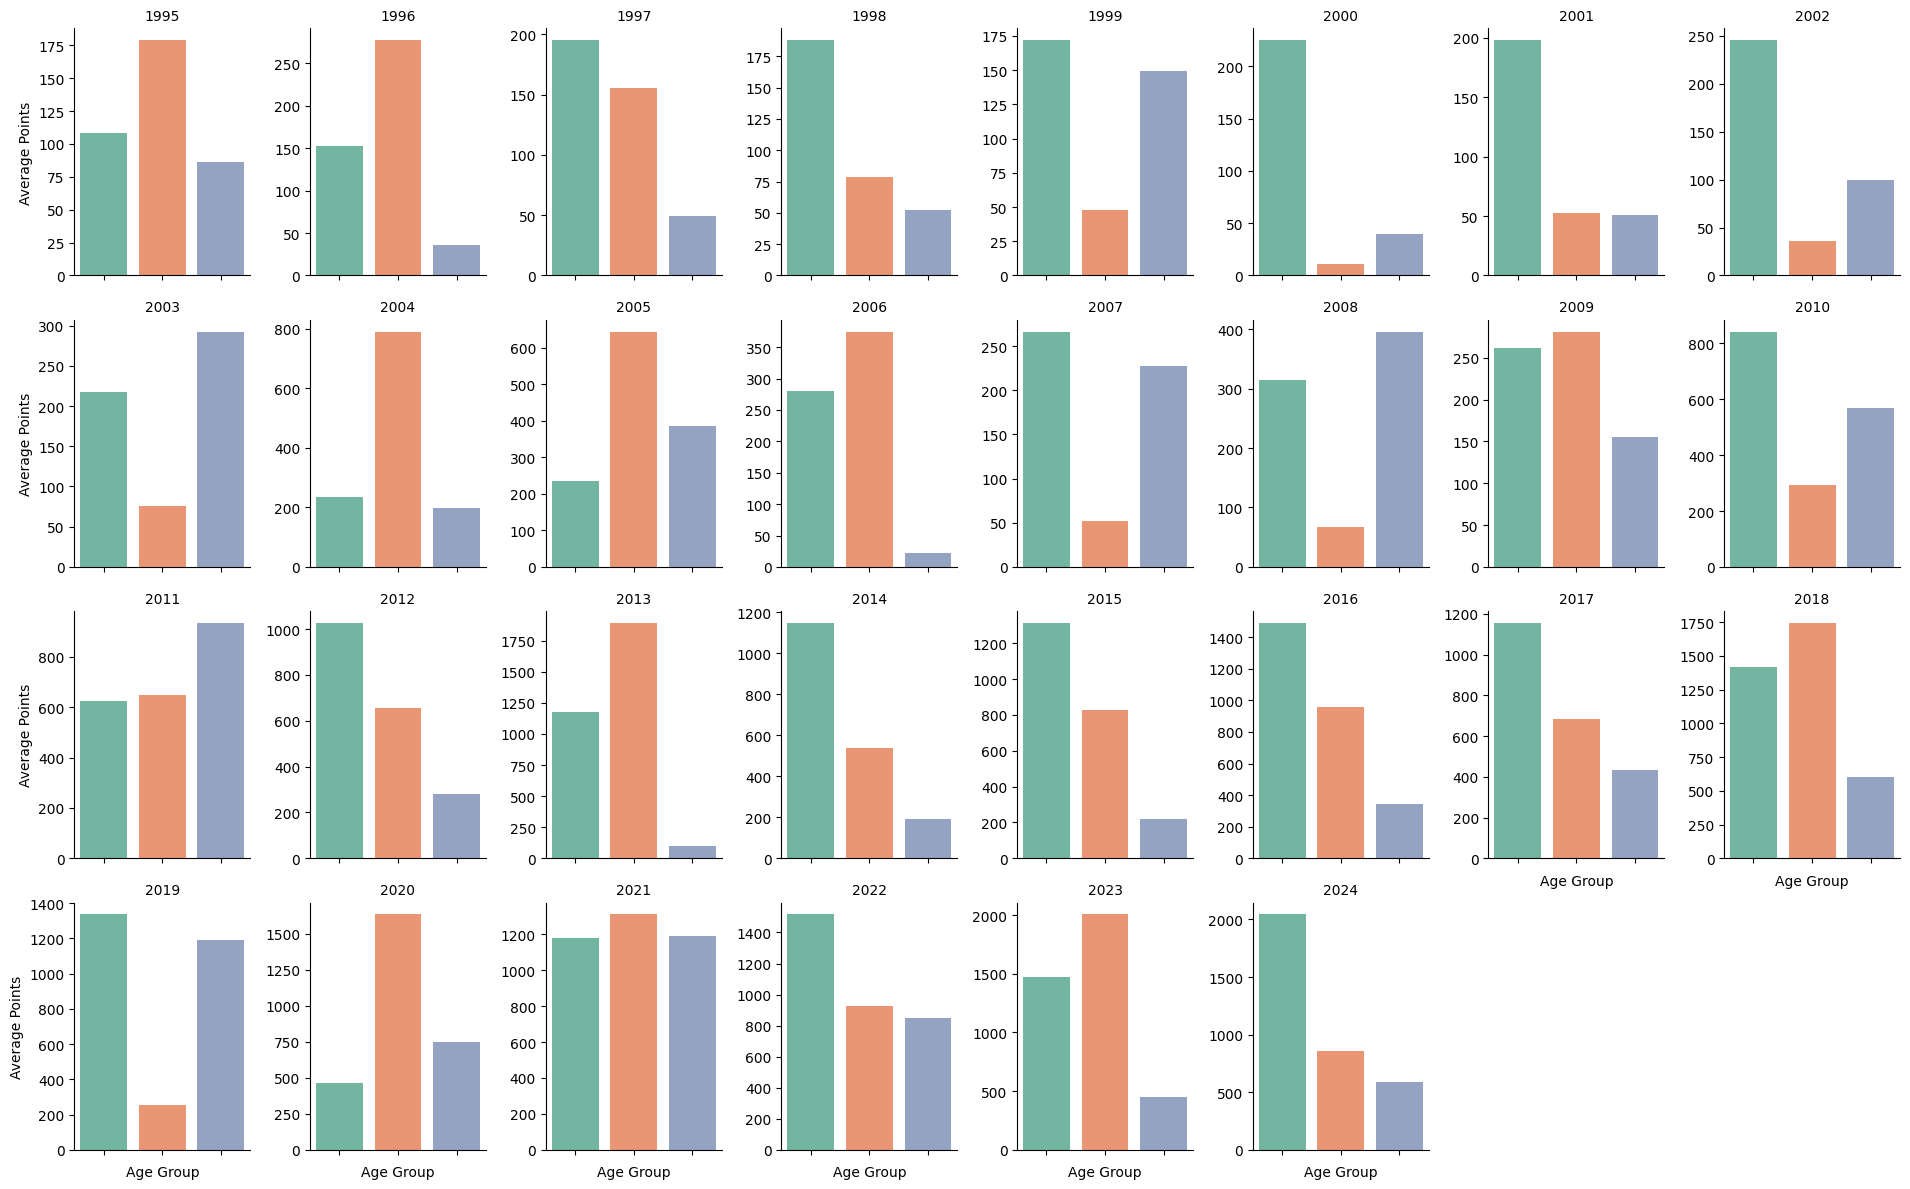


Driver Age Group Comparison Interpretation:

Driver Age Group Comparison Interpretation:
1. Young Drivers (<25): On average, young drivers scored 364.37 points across 185 races.
2. Middle Drivers (25–34): Middle-aged drivers averaged 716.98 points over 449 races.
3. Older Drivers (35+): Older drivers achieved an average of 611.95 points across 91 races.
These statistics indicate how different age groups perform in accumulating points and securing wins throughout the seasons.


In [22]:
# --------------------------
# Age Comparison: Average Points and Total Wins by Age Group
# --------------------------
age_comparison = driver_groups.groupby(['year', 'age_group'], as_index=False).agg(
    avg_points=('total_points', 'mean'),
    total_wins=('total_wins', 'sum'),
    driver_count=('driverId', 'nunique')
)

print("Driver Age Group Comparison by Year:")
print(age_comparison)

# --------------------------
# Visualization: Average Points by Driver Age Group Faceted by Year
# --------------------------
# Set up faceted plot using seaborn's catplot
g = sns.catplot(
    data=age_comparison,
    x='age_group',
    y='avg_points',
    hue='age_group',
    col='year',
    col_wrap=8,
    kind='bar',
    height=3,
    aspect=0.8,
    palette='Set2',
    sharey=False
)

g.set_titles("{col_name}")
g.set_axis_labels("Age Group", "Average Points")
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

# --------------------------
# Automated Interpretation for Age Comparison
# --------------------------
def mean_points(age_group_name):
    subset = age_comparison[age_comparison['age_group'] == age_group_name]
    return round(subset['avg_points'].mean(), 2)

def total_races(age_group_name):
    subset = age_comparison[age_comparison['age_group'] == age_group_name]
    return subset['driver_count'].sum()

interpret_age_comparison = (
    f"Driver Age Group Comparison Interpretation:\n"
    f"1. Young Drivers (<25): On average, young drivers scored {mean_points('Young (<25)')} points across {total_races('Young (<25)')} races.\n"
    f"2. Middle Drivers (25–34): Middle-aged drivers averaged {mean_points('Middle (25–34)')} points over {total_races('Middle (25–34)')} races.\n"
    f"3. Older Drivers (35+): Older drivers achieved an average of {mean_points('Older (35+)')} points across {total_races('Older (35+)')} races.\n"
    f"These statistics indicate how different age groups perform in accumulating points and securing wins throughout the seasons."
)

print("\nDriver Age Group Comparison Interpretation:\n")
print(interpret_age_comparison)


### 4.4 Discussion

The analysis demonstrates that older, more experienced drivers tend to accumulate more points on average compared to their younger counterparts. However, there are exceptions where younger drivers perform exceptionally well, often due to being part of strong teams or showcasing remarkable talent. Consistency, as measured by the standard deviation of race positions, indicates that drivers with lower variability in their race finishes tend to perform more reliably, suggesting stable performance and effective team support.

### 4.5 Conclusions

**Conclusions:**

1.  **Positional Shifts:** Drivers who significantly improve their standings from the beginning to the end of a season exhibit adaptability, consistent scoring, and effective race strategies.
    
2.  **Consistency:** Drivers with low standard deviation in their race positions demonstrate high consistency, reflecting reliable performance and stable driver-team dynamics.
    
3.  **Age Factor:** Older, experienced drivers generally score more points on average, indicating the benefits of experience and maturity. However, young drivers can excel under strong team environments or through exceptional performance.
    
4.  **Influencing Factors:** While age plays a role in driver performance, factors such as team environment, car performance, and strategic management are significant determinants of success.
    
5.  **Further Steps:** Incorporate additional data such as race-level incidents, mechanical issues, and qualifying vs. race position metrics to deepen the analysis of driver performance trends.


## 5. Top “Starters” and “Finishers” Analysis

### 5.1 Introduction

Identifying drivers who consistently gain or lose positions from their starting grid to the race finish provides insights into their racecraft and the effectiveness of their teams' strategies. This analysis quantifies these trends to highlight top "starters" and "finishers."

### 5.2 Methodology

#### 5.2.1 Data Filtering and Preparation

We filter the results to include only races from 1995 onwards and calculate the positions gained or lost by each driver in each race.

In [23]:

# Ensure 'grid' and 'positionOrder' are numeric (Equivalent to mutate/as.numeric)
# We use pd.to_numeric with 'coerce' to turn non-convertible values into NaN.
results['grid'] = pd.to_numeric(results['grid'], errors='coerce')
results['positionOrder'] = pd.to_numeric(results['positionOrder'], errors='coerce')

# Store original row count for the summary
original_rows = len(results)

# Filter out rows with NA in 'grid' or 'positionOrder' (Equivalent to filter/!is.na)
results_clean = results[
    results['grid'].notna() & results['positionOrder'].notna()
].copy() # .copy() is good practice to avoid SettingWithCopyWarning

# Calculate positions gained (Equivalent to mutate)
results_clean['start_position'] = results_clean['grid']
results_clean['final_position'] = results_clean['positionOrder']
results_clean['positions_gained'] = (
    results_clean['start_position'] - results_clean['final_position']
)

# Summary of cleaning (Equivalent to tibble)
cleaned_rows = len(results_clean)
rows_removed = original_rows - cleaned_rows

cleaning_star_finish = pd.DataFrame({
    'Original_Rows': [original_rows],
    'Cleaned_Rows': [cleaned_rows],
    'Rows_Removed': [rows_removed]
})

print(cleaning_star_finish)

   Original_Rows  Cleaned_Rows  Rows_Removed
0          11914         11914             0



#### 5.2.2 Aggregation and Summaries

We calculate each driver's average and total positions gained across all races from 1995 onwards.

In [24]:

# Aggregate positions gained per driver across all races from 1995 onward
# Equivalent to group_by/summarise
driver_start_finish = results_clean.groupby('driverId').agg(
    # Count the number of non-NA races for each driver
    races_count=('raceId', 'count'),

    # Calculate the mean of positions gained. Since we filtered out NAs in the previous step,
    # 'na.rm=TRUE' is implicitly handled.
    avg_positions_gained=('positions_gained', 'mean'),

    # Calculate the sum of positions gained
    total_positions_gained=('positions_gained', 'sum')
).reset_index()

# Print the entire DataFrame (Equivalent to print(..., n = Inf))
print(driver_start_finish)

     driverId  races_count  avg_positions_gained  total_positions_gained
0           1          356             -0.719101                    -256
1           2          184              0.614130                     113
2           3          206             -1.349515                    -278
3           4          404              0.086634                      35
4           5          112              0.455357                      51
5           6           36              0.722222                      26
6           7           27              0.666667                      18
7           8          352             -0.963068                    -339
8           9           99             -1.050505                    -104
9          10           95              1.768421                     168
10         11           91              1.087912                      99
11         12           28              0.285714                       8
12         13          271             -0.619926   


#### 5.2.3 Joining with Drivers for Names

We merge the aggregated data with driver information to facilitate interpretation.

In [25]:

# Join with drivers data to get driver names and nationalities (Equivalent to left_join)
starters_vs_finishers_temp = pd.merge(
    driver_start_finish,
    drivers,
    on='driverId',
    how='left'
)

# Select and reorder relevant columns (Equivalent to select)
starters_vs_finishers = starters_vs_finishers_temp.loc[:, [
    'driverRef',
    'forename',
    'surname',
    'nationality',
    'races_count',
    'avg_positions_gained',
    'total_positions_gained'
]]

# Print the entire DataFrame (Equivalent to print(..., n = Inf))
print(starters_vs_finishers)

              driverRef         forename        surname    nationality  \
0              hamilton            Lewis       Hamilton        British   
1              heidfeld             Nick       Heidfeld         German   
2               rosberg             Nico        Rosberg         German   
3                alonso         Fernando         Alonso        Spanish   
4            kovalainen           Heikki     Kovalainen        Finnish   
5              nakajima           Kazuki       Nakajima       Japanese   
6              bourdais        Sébastien       Bourdais         French   
7             raikkonen             Kimi      Räikkönen        Finnish   
8                kubica           Robert         Kubica         Polish   
9                 glock             Timo          Glock         German   
10                 sato           Takuma           Sato       Japanese   
11            piquet_jr           Nelson     Piquet Jr.      Brazilian   
12                massa           Feli


### 5.3 Results

#### 5.3.1 Top 10 Drivers in Average Positions Gained

In [26]:


# Identify top 10 drivers with highest average positions gained
# Equivalent to arrange(desc()) %>% slice_head(n = 10)
top_gainers = starters_vs_finishers.sort_values(
    by='avg_positions_gained',
    ascending=False
).head(10).copy()

print("Top Gainers DataFrame:")
print(top_gainers)

# Automated Interpretation for Top Gainers (Equivalent to glue/paste/cat)

# Create a list of descriptive strings, one for each driver in the top 10
interpretation_lines = [
    (
        f"{row['forename']} {row['surname']} "
        f"from {row['nationality']} "
        f"have an average gain of {row['avg_positions_gained']:.2f} "
        f"positions over {row['races_count']} races."
    )
    for index, row in top_gainers.iterrows()
]

# Combine the lines with a newline separator
interpret_top_gainers_overall = "\n".join(interpretation_lines)

print("\nTop 10 Drivers in Average Positions Gained Interpretation:")
print(interpret_top_gainers_overall)

Top Gainers DataFrame:
             driverRef    forename     surname nationality  races_count  \
59           mazzacane      Gastón   Mazzacane   Argentine           21   
52               kiesa     Nicolas       Kiesa      Danish            5   
97            deletraz  Jean-Denis    Délétraz       Swiss            2   
47                gene        Marc        Gené     Spanish           36   
81             fontana    Norberto     Fontana   Argentine            4   
89              moreno     Roberto      Moreno   Brazilian           17   
98            tarquini    Gabriele    Tarquini     Italian            1   
60                enge       Tomáš        Enge       Czech            3   
27   markus_winkelhock      Markus  Winkelhock      German            1   
106           chandhok       Karun    Chandhok      Indian           11   

     avg_positions_gained  total_positions_gained  
59               7.047619                     148  
52               6.600000                      


#### 5.3.2 Total Positions Gained

In [27]:

# Identify top 10 drivers with highest total positions gained
# Equivalent to arrange(desc()) %>% slice_head(n = 10)
top_total_gainers = starters_vs_finishers.sort_values(
    by='total_positions_gained',
    ascending=False
).head(10).copy()

print("Top Total Gainers DataFrame:")
print(top_total_gainers)

# Automated Interpretation for Top Total Gainers (Equivalent to glue/paste/cat)

# Create a list of descriptive strings, one for each driver in the top 10
interpretation_lines = [
    (
        f"{row['forename']} {row['surname']} "
        f"from {row['nationality']} "
        f"have gained a total of {row['total_positions_gained']:.0f} " # Use .0f for whole numbers
        f"positions over {row['races_count']} races."
    )
    for index, row in top_total_gainers.iterrows()
]

# Combine the lines with a newline separator
interpret_top_total_gainers = "\n".join(interpretation_lines)

print("\nTop 10 Drivers in Total Positions Gained Interpretation:")
print(interpret_top_total_gainers)

Top Total Gainers DataFrame:
      driverRef forename     surname nationality  races_count  \
62         salo     Mika        Salo     Finnish          109   
49   verstappen      Jos  Verstappen       Dutch           97   
63        diniz    Pedro       Diniz   Brazilian           99   
47         gene     Marc        Gené     Spanish           36   
68       badoer     Luca      Badoer     Italian           44   
122    ericsson   Marcus    Ericsson     Swedish           97   
9         glock     Timo       Glock      German           95   
74       nakano   Shinji      Nakano    Japanese           33   
59    mazzacane   Gastón   Mazzacane   Argentine           21   
134      stroll    Lance      Stroll    Canadian          168   

     avg_positions_gained  total_positions_gained  
62               2.376147                     259  
49               2.618557                     254  
63               2.474747                     245  
47               5.916667                     2

#### 5.3.3 Visualizing Gainers vs. Losers


Gainers vs. Losers Visualization Interpretation:
Gainers vs. Losers Visualization Interpretation:
The scatter plot illustrates the relationship between the average positions gained per race and the total positions gained by drivers who have participated in at least 10 races since 1995. Drivers positioned towards the top-right corner are those who consistently gain positions and have accumulated a significant total gain over their careers. Labeling the top 5 drivers with the highest total positions gained highlights their exceptional performance in outperforming their starting positions.


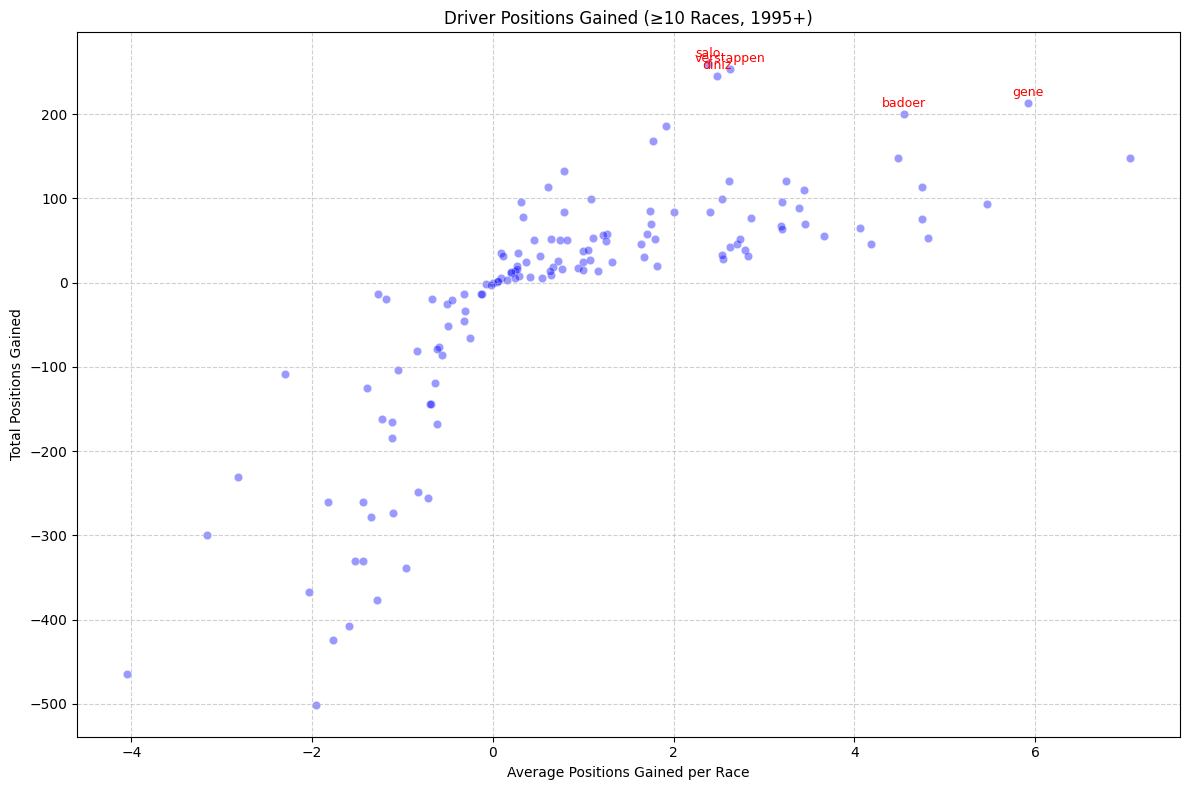

In [28]:


# Filter drivers with at least 10 races (Equivalent to filter)
filtered_drivers = starters_vs_finishers[
    starters_vs_finishers['races_count'] >= 10
].copy()

# Get the top 5 drivers with the highest total positions gained for labeling
# Equivalent to filtered_drivers %>% slice_max(total_positions_gained, n = 5)
top_5_total_gainers = filtered_drivers.sort_values(
    by='total_positions_gained',
    ascending=False
).head(5)

# Plot Average Positions Gained vs Total Positions Gained (Equivalent to ggplot)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='avg_positions_gained',
    y='total_positions_gained',
    data=filtered_drivers,
    alpha=0.4,
    color='blue'
)

# Add driver labels for the top 5 total gainers (Equivalent to geom_text)
# Use a loop to annotate each of the top 5 drivers
for index, row in top_5_total_gainers.iterrows():
    plt.annotate(
        row['driverRef'],
        (row['avg_positions_gained'], row['total_positions_gained']),
        textcoords="offset points", # position text relative to Data
        xytext=(0, 5),               # nudge text up a bit
        ha='center',                 # horizontal alignment
        fontsize=9,
        color='red'
    )

plt.title("Driver Positions Gained (≥10 Races, 1995+)")
plt.xlabel("Average Positions Gained per Race")
plt.ylabel("Total Positions Gained")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plot_filename = "gainers_vs_losers_plot.png"
plt.savefig(plot_filename)
# plt.show() # In a notebook environment, this displays the plot

# Automated Interpretation (Equivalent to glue/cat)
interpret_gainers_vs_losers = (
    "Gainers vs. Losers Visualization Interpretation:\n"
    "The scatter plot illustrates the relationship between the average positions gained per race and the total positions gained by drivers who have participated in at least 10 races since 1995. "
    "Drivers positioned towards the top-right corner are those who consistently gain positions and have accumulated a significant total gain over their careers. "
    "Labeling the top 5 drivers with the highest total positions gained highlights their exceptional performance in outperforming their starting positions."
)

print("\nGainers vs. Losers Visualization Interpretation:")
print(interpret_gainers_vs_losers)

### 5.4 Discussion

Drivers who consistently gain positions from their starting grid demonstrate strong racecraft, effective tire management, and strategic pit stops. These drivers often start outside the top positions but leverage race dynamics to improve their standings. On the other hand, drivers who frequently lose positions may benefit from strong qualifying setups but struggle with race pace, reliability, or consistency during races.

### 5.5 Conclusions

**Conclusions:**

1.  **Starters vs. Finishers:** The analysis highlights drivers who consistently move forward in races since 1995. Drivers with high average and total position gains typically start outside the top 10 but excel in race conditions through effective strategies and performance.
    
2.  **High Gains:** Drivers exhibiting significant position gains demonstrate exceptional racecraft and adaptability, capitalizing on opportunities during races to overtake competitors.
    
3.  **High Losses:** Drivers who consistently lose positions may benefit from strong qualifying setups but require improvements in race pace, reliability, or strategic execution to enhance their race performance.
    
4.  **Strategic Implications:** Teams can utilize this data to refine their race strategies, focusing on improving race performance for drivers who gain positions and addressing the factors causing position losses for others.


## 6. Lap Times and Their Decrease/Increase During the Race

### 6.1 Introduction

Lap times are a fundamental metric in Formula 1, reflecting a driver's pace, consistency, and performance throughout a race. Analyzing lap times provides insights into drivers' race strategies, car performance, and adaptability under varying race conditions. This analysis explores the stability of individual drivers' race pace and compares their best lap times across different phases of the race (beginning, middle, end).

### 6.2 Data Description

The analysis utilizes the **lap_times** dataset from Formula 1 races spanning from 1995 onwards. The key columns of interest include:

-   **raceId:** Identifier for each race.
-   **driverId:** Identifier for each driver.
-   **lap:** The lap number within the race.
-   **position:** Driver's position at the end of the lap.
-   **time:** Lap time in "minutes:seconds.milliseconds" format.
-   **milliseconds:** Lap time in milliseconds.

Additional relevant datasets include:

-   **races:** Contains information about each race, including the year and total number of laps.
-   **drivers:** Contains driver details, including name and nationality.

### 6.3 Methodology

#### 6.3.1 Data Validation and Cleaning

We begin by loading the necessary libraries and datasets, filtering for races from 1995 onwards, and cleaning the data to ensure accuracy in lap time measurements.

In [29]:
try:
    lap_times = pd.read_csv("Data/lap_times.csv")
    races = pd.read_csv("Data/races.csv")
    drivers = pd.read_csv("Data/drivers.csv")
    print("Data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Necessary CSV files not found. Please ensure they are accessible.")
    # Stop execution if data is missing
    # raise

# Store original row count of the lap_times DataFrame before any filtering
# Use a placeholder if loading failed
original_lap_times_rows = len(lap_times) if 'lap_times' in locals() else 0


# --- 2. Data Filtering (Equivalent to filter) ---

# Filter races from 1995 onwards (races %>% filter(year >= 1995))
races_filtered = races[races['year'] >= 1995].copy()
race_ids_filtered = races_filtered['raceId']

# Filter lap_times for races from 1995 onwards (lap_times %>% filter(raceId %in% races_filtered$raceId))
lap_times_filtered = lap_times[
    lap_times['raceId'].isin(race_ids_filtered)
].copy()


# --- 3. Data Cleaning (Equivalent to mutate/filter) ---

# Convert 'milliseconds' to numeric (Equivalent to mutate/as.numeric)
lap_times_filtered['milliseconds'] = pd.to_numeric(
    lap_times_filtered['milliseconds'],
    errors='coerce' # Convert non-numeric/invalid values to NaN
)

# Handle potential missing or invalid lap times 
# (Equivalent to filter(!is.na(milliseconds) & milliseconds > 0))
lap_times_clean = lap_times_filtered[
    lap_times_filtered['milliseconds'].notna() &
    (lap_times_filtered['milliseconds'] > 0)
].copy()


# --- 4. Summary of Cleaning (Equivalent to tibble) ---

# Note: The R code calculates removal from the *lap_times_filtered* set, 
# not the *Original_Rows*.
cleaned_rows = len(lap_times_clean)
rows_in_filtered_set = len(lap_times_filtered)
rows_removed = rows_in_filtered_set - cleaned_rows

cleaning_summary = pd.DataFrame({
    'Original_Rows': [original_lap_times_rows],
    'Filtered_Races_Rows': [rows_in_filtered_set],
    'Cleaned_Rows': [cleaned_rows],
    'Rows_Removed_In_Cleaning_Step': [rows_removed]
})

print(cleaning_summary)

Data files loaded successfully.
   Original_Rows  Filtered_Races_Rows  Cleaned_Rows  \
0         589081               589081        589081   

   Rows_Removed_In_Cleaning_Step  
0                              0  



#### 6.3.2 Analyzing Race Pace Stability

To assess the stability of drivers' race pace, we calculate the standard deviation of lap times for each driver in each race. A lower standard deviation indicates more consistent lap times.

In [30]:
# Calculate standard deviation of lap times per driver per race
# Equivalent to group_by/summarise
race_pace = lap_times_clean.groupby(['raceId', 'driverId']).agg(
    # Calculate mean lap time in milliseconds
    mean_lap_time=('milliseconds', 'mean'),
    
    # Calculate standard deviation of lap time in milliseconds
    sd_lap_time=('milliseconds', 'std'),
    
    # Count the total number of laps
    total_laps=('lap', 'count') 
    
).reset_index() # .groups = "drop" is handled by reset_index()

# Merge with drivers data to get driver names (Equivalent to left_join/select)
race_pace_named_temp = pd.merge(
    race_pace,
    drivers,
    on='driverId',
    how='left'
)

# Select and reorder relevant columns
race_pace_named = race_pace_named_temp.loc[:, [
    'driverRef',
    'forename',
    'surname',
    'nationality',
    'raceId',
    'mean_lap_time',
    'sd_lap_time',
    'total_laps'
]]

print(race_pace_named)

                driverRef      forename        surname    nationality  raceId  \
0                hamilton         Lewis       Hamilton        British       1   
1                heidfeld          Nick       Heidfeld         German       1   
2                 rosberg          Nico        Rosberg         German       1   
3                  alonso      Fernando         Alonso        Spanish       1   
4                nakajima        Kazuki       Nakajima       Japanese       1   
5                bourdais     Sébastien       Bourdais         French       1   
6               raikkonen          Kimi      Räikkönen        Finnish       1   
7                  kubica        Robert         Kubica         Polish       1   
8                   glock          Timo          Glock         German       1   
9               piquet_jr        Nelson     Piquet Jr.      Brazilian       1   
10                  massa        Felipe          Massa      Brazilian       1   
11                 trulli   


#### 6.3.3 Comparing Best Lap Times Across Race Phases

We divide each race into three phases: beginning, middle, and end. For each driver in each race, we identify their best lap time in each phase.

In [31]:
# --- 1. Calculate total laps per race
race_laps = lap_times_clean.groupby('raceId').agg(
    total_laps=('lap', 'max')
).reset_index()

# --- 2. Merge total laps and Define race phases
lap_times_phases = pd.merge(lap_times_clean, race_laps, on='raceId', how='left')

# Define the conditions for the three phases
conditions = [
    # Beginning: First 30% of laps
    lap_times_phases['lap'] <= 0.3 * lap_times_phases['total_laps'],
    # Middle: 30% to 70% of laps
    (lap_times_phases['lap'] > 0.3 * lap_times_phases['total_laps']) & 
    (lap_times_phases['lap'] <= 0.7 * lap_times_phases['total_laps']),
    # End: Last 30% of laps
    lap_times_phases['lap'] > 0.7 * lap_times_phases['total_laps']
]

# Define the corresponding phase labels
choices = ['Beginning', 'Middle', 'End']

# FIX: Change the default value from np.nan (float) to 'Unknown' (string) 
# or use a string representation of NaN, e.g., 'NaN' or ''
lap_times_phases['phase'] = np.select(conditions, choices, default='Unknown')


# --- 3. Calculate best lap time per driver per phase
best_laps_phase = lap_times_phases.groupby(['raceId', 'driverId', 'phase']).agg(
    best_lap_time=('milliseconds', 'min') 
).reset_index()

# --- 4. Merge with drivers data
best_laps_phase_named_temp = pd.merge(
    best_laps_phase,
    drivers,
    on='driverId',
    how='left'
)

# Select and reorder relevant columns
best_laps_phase_named = best_laps_phase_named_temp.loc[:, [
    'driverRef',
    'forename',
    'surname',
    'nationality',
    'raceId',
    'phase',
    'best_lap_time'
]]

print(best_laps_phase_named)

                driverRef      forename        surname    nationality  raceId  \
0                hamilton         Lewis       Hamilton        British       1   
1                hamilton         Lewis       Hamilton        British       1   
2                hamilton         Lewis       Hamilton        British       1   
3                heidfeld          Nick       Heidfeld         German       1   
4                heidfeld          Nick       Heidfeld         German       1   
5                heidfeld          Nick       Heidfeld         German       1   
6                 rosberg          Nico        Rosberg         German       1   
7                 rosberg          Nico        Rosberg         German       1   
8                 rosberg          Nico        Rosberg         German       1   
9                  alonso      Fernando         Alonso        Spanish       1   
10                 alonso      Fernando         Alonso        Spanish       1   
11                 alonso   


### 6.4 Results

#### 6.4.1 Race Pace Stability

Summary Statistics of Lap Time Standard Deviation:
                   avg_sd    median_sd      min_sd        max_sd
sd_lap_time  22662.749717  6658.662726  166.170094  1.394070e+06


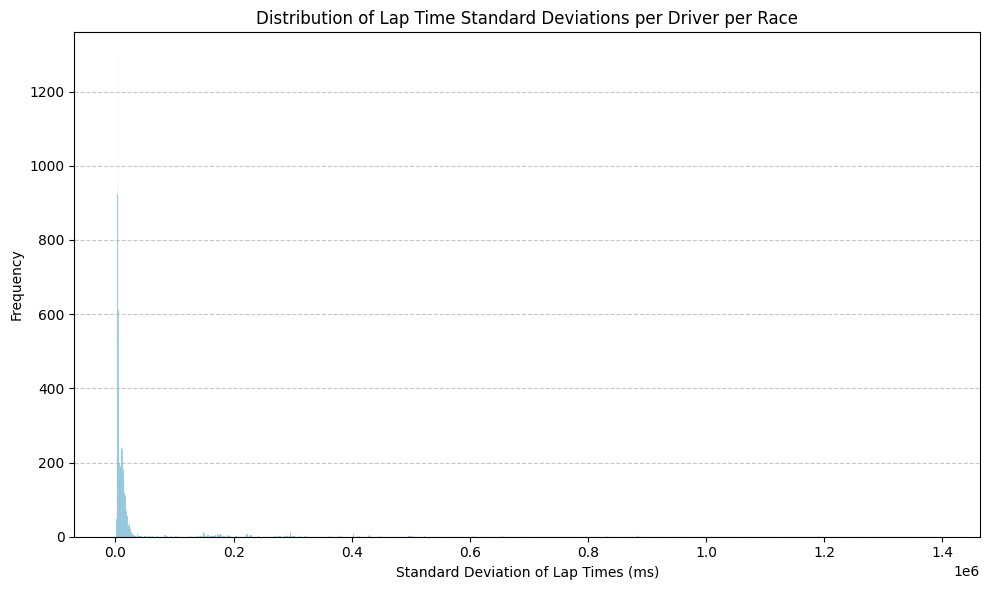

In [32]:


# 1. Filter races from 1995 onwards
races_filtered = races[races['year'] >= 1995].copy()
race_ids_filtered = races_filtered['raceId']

# 2. Filter lap_times and clean (assuming 'lap_times' is the original DF)
lap_times_filtered = lap_times[lap_times['raceId'].isin(race_ids_filtered)].copy()
lap_times_filtered['milliseconds'] = pd.to_numeric(lap_times_filtered['milliseconds'], errors='coerce')
lap_times_clean = lap_times_filtered[
    lap_times_filtered['milliseconds'].notna() & (lap_times_filtered['milliseconds'] > 0)
].copy()

# 3. Calculate standard deviation of lap times per driver per race
race_pace = lap_times_clean.groupby(['raceId', 'driverId']).agg(
    mean_lap_time=('milliseconds', 'mean'),
    sd_lap_time=('milliseconds', 'std'),
    total_laps=('lap', 'count')
).reset_index()

# 4. Merge with drivers data
race_pace_named_temp = pd.merge(race_pace, drivers, on='driverId', how='left')
race_pace_named = race_pace_named_temp.loc[:, [
    'driverRef', 'forename', 'surname', 'nationality', 'raceId', 'mean_lap_time', 'sd_lap_time', 'total_laps'
]]

# --- Requested Conversion Block ---

# Summary statistics of lap time standard deviation (Equivalent to summarise)
# Use .agg() on the desired column and then transpose to get the R-like single row format
pace_summary = race_pace_named['sd_lap_time'].agg(
    avg_sd='mean',
    median_sd='median',
    min_sd='min',
    max_sd='max'
).to_frame().T

print("Summary Statistics of Lap Time Standard Deviation:")
print(pace_summary)

# Visualization: Distribution of Lap Time Standard Deviations (Equivalent to ggplot/geom_histogram)
plt.figure(figsize=(10, 6))

# Use seaborn's histplot. binwidth=500ms as specified in the R code.
sns.histplot(
    data=race_pace_named,
    x='sd_lap_time',
    binwidth=500,
    color="skyblue",
    edgecolor="black"
)

plt.title("Distribution of Lap Time Standard Deviations per Driver per Race")
plt.xlabel("Standard Deviation of Lap Times (ms)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plot_filename = "lap_time_sd_distribution.png"
plt.savefig(plot_filename)
# plt.show()

#### 6.4.2 Comparing Best Lap Times Across Race Phases

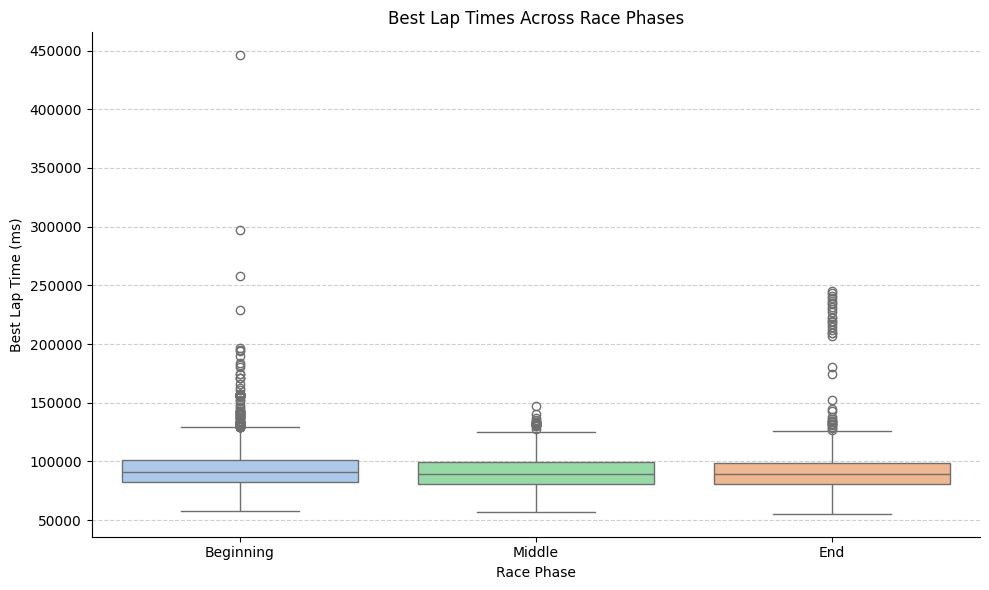

In [33]:


# Visualization: Best Lap Times by Race Phase (Equivalent to ggplot/geom_boxplot)
plt.figure(figsize=(10, 6))

# Define the order for the x-axis categories
phase_order = ['Beginning', 'Middle', 'End']

# Create the boxplot
sns.boxplot(
    x='phase',
    y='best_lap_time',
    data=best_laps_phase_named,
    # Set the order of phases
    order=phase_order,
    # Use 'phase' to determine color/fill
    hue='phase', 
    dodge=False, # Important to prevent grouping if 'hue' is used
    palette="pastel" # A color palette
)

# Apply labeling and theme (Equivalent to labs/theme_minimal)
plt.title("Best Lap Times Across Race Phases")
plt.xlabel("Race Phase")
plt.ylabel("Best Lap Time (ms)")

# Remove legend (Equivalent to theme(legend.position = "none"))
plt.legend([],[], frameon=False) 

# Apply minimal theme elements (e.g., remove top/right spines)
sns.despine()

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plot_filename = "best_lap_times_by_phase_boxplot.png"
plt.savefig(plot_filename)
# plt.show()

#### 6.4.3 Top Drivers with Most Consistent Race Pace

Top 10 Most Consistent Drivers:
    driverRef  forename   surname nationality  avg_sd_pace  races_competed
118  sarrazin  Stéphane  Sarrazin      French  2630.987259               1
30     doohan      Jack    Doohan  Australian  5119.091808               1
69    lavaggi  Giovanni   Lavaggi     Italian  5431.707683               3
11     berger   Gerhard    Berger    Austrian  6676.870925              30
47   hakkinen      Mika  Häkkinen     Finnish  7200.959579              94
54     irvine     Eddie    Irvine     British  7203.697435             110
36    fontana  Norberto   Fontana   Argentine  7241.725630               4
112    rosset   Ricardo    Rosset   Brazilian  7296.445583              25
84      merhi   Roberto     Merhi     Spanish  7393.595881              13
122   stevens      Will   Stevens     British  7495.419829              18


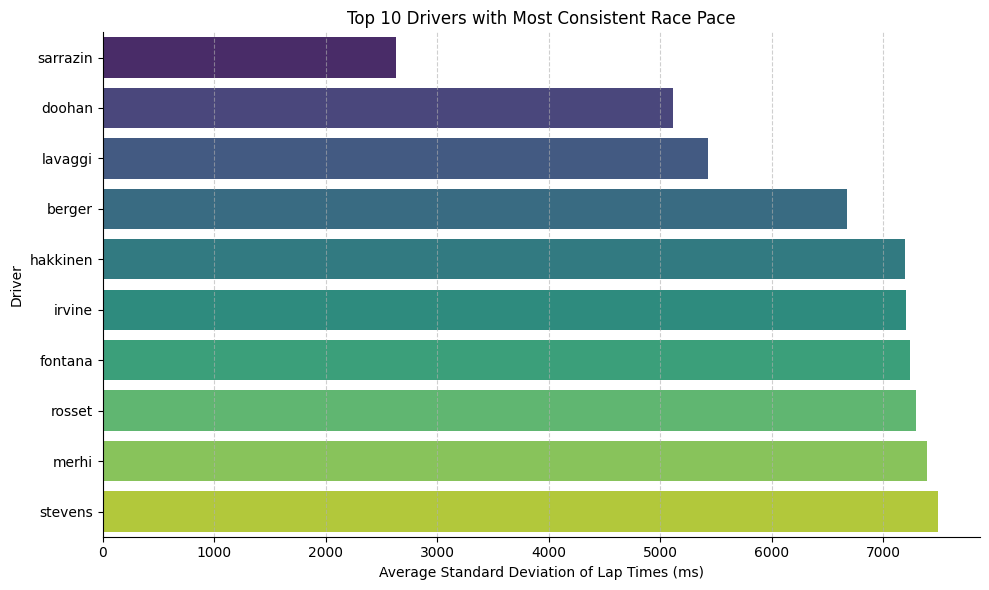

In [34]:


# 1. Aggregate and calculate average SD per driver (Equivalent to group_by/summarise)
driver_consistency = race_pace_named.groupby(['driverRef', 'forename', 'surname', 'nationality']).agg(
    avg_sd_pace=('sd_lap_time', 'mean'), # average standard deviation of lap times
    races_competed=('raceId', 'count')   # count of races used in the aggregation
).reset_index()

# 2. Identify top 10 drivers with lowest average standard deviation (most consistent)
# (Equivalent to arrange(avg_sd_pace) %>% slice_head(n = 10))
top_consistent_drivers = driver_consistency.sort_values(
    by='avg_sd_pace',
    ascending=True
).head(10).copy()

print("Top 10 Most Consistent Drivers:")
print(top_consistent_drivers)

# 3. Visualization: Top 10 Consistent Drivers' Average Lap Time SD
# (Equivalent to ggplot/geom_bar/coord_flip)

plt.figure(figsize=(10, 6))

# Create the horizontal bar chart
# The reorder(driverRef, avg_sd_pace) in R is handled by setting the order 
# of the y-axis categories based on the sorted DataFrame.
sns.barplot(
    x='avg_sd_pace',
    y='driverRef',
    data=top_consistent_drivers,
    # Use driverRef as hue to mimic the R code's fill=driverRef, 
    # ensuring each bar has a distinct color if needed, but the legend is removed later.
    hue='driverRef', 
    dodge=False,
    palette="viridis" 
)

# Apply labeling and theme (Equivalent to labs/theme_minimal)
plt.title("Top 10 Drivers with Most Consistent Race Pace")
plt.xlabel("Average Standard Deviation of Lap Times (ms)")
plt.ylabel("Driver")

# Remove legend (Equivalent to theme(legend.position = "none"))
plt.legend([],[], frameon=False) 

# Apply minimal theme elements
sns.despine()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot
plot_filename = "top_consistent_drivers_pace.png"
plt.savefig(plot_filename)
# plt.show()

#### 6.4.4 Top Drivers in Best Lap Times by Race Phase

Top 10 Fastest Best Lap Times per Race Phase:
     driverRef   forename     surname nationality  raceId      phase  \
0      russell     George     Russell     British    1046        End   
1       bottas   Valtteri      Bottas     Finnish    1046     Middle   
2      russell     George     Russell     British    1046     Middle   
3        perez     Sergio       Pérez     Mexican    1046        End   
4   giovinazzi    Antonio  Giovinazzi     Italian    1046     Middle   
5       vettel  Sebastian      Vettel      German    1046     Middle   
6        perez     Sergio       Pérez     Mexican    1046     Middle   
7    ricciardo     Daniel   Ricciardo  Australian    1046     Middle   
8        kvyat     Daniil       Kvyat     Russian    1046        End   
9       bottas   Valtteri      Bottas     Finnish    1046        End   
10       albon  Alexander       Albon        Thai    1046     Middle   
11       albon  Alexander       Albon        Thai    1046        End   
12       sainz    

C:\Users\n12540447\AppData\Local\Temp\ipykernel_3808\3788292785.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


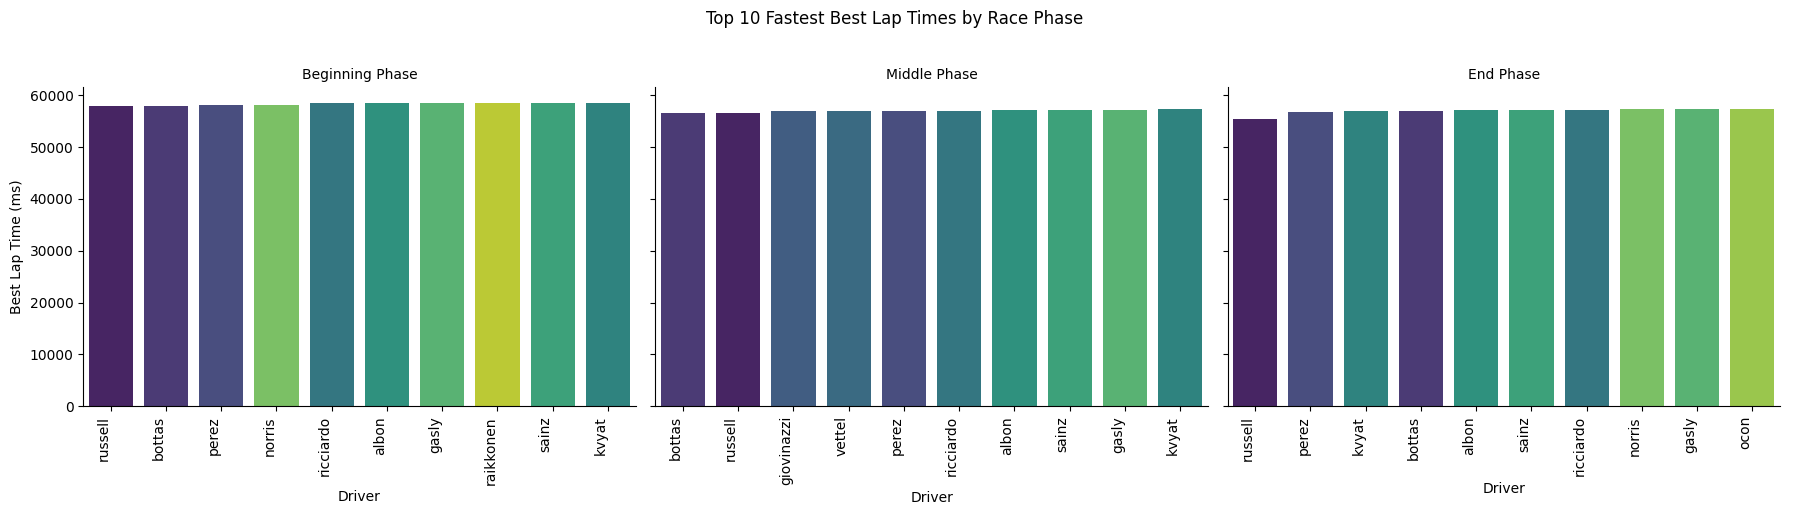

In [35]:

# 1. Identify top 10 drivers with fastest best lap times in each phase
# Equivalent to group_by(phase) %>% arrange(best_lap_time) %>% slice_head(n = 10) %>% ungroup()
top_best_laps = (
    best_laps_phase_named
    .sort_values(by='best_lap_time', ascending=True)
    .groupby('phase')
    .head(10)
    .reset_index(drop=True)
)

print("Top 10 Fastest Best Lap Times per Race Phase:")
print(top_best_laps)


# 2. Visualization: Fastest Best Lap Times by Race Phase
# Equivalent to ggplot/geom_bar/facet_wrap/theme(axis.text.x = element_text(angle = 90, hjust = 1))

# Define the order for the phases for consistent plotting (optional, but good practice)
phase_order = ['Beginning', 'Middle', 'End']

# Create the faceted bar chart using seaborn.catplot
# Catplot handles the faceting (facet_wrap) and bar chart (geom_bar).
g = sns.catplot(
    data=top_best_laps,
    x='driverRef',
    y='best_lap_time',
    col='phase',        # Facet by phase
    kind='bar',
    col_order=phase_order,
    sharey=True,        # Share Y-axis scale (Lap Time)
    sharex=False,       # Do not share X-axis (Driver names differ per phase, similar to scales="free_x")
    palette="viridis",
    aspect=1.2 # Control the width-to-height ratio of each facet
)

# Set titles and labels
g.fig.suptitle("Top 10 Fastest Best Lap Times by Race Phase", y=1.02)
g.set_axis_labels("Driver", "Best Lap Time (ms)")
g.set_titles("{col_name} Phase") # Title each facet

# Handle X-axis labels rotation and alignment (Equivalent to theme(axis.text.x = element_text(angle = 90, hjust = 1)))
for ax in g.axes.flat:
    # Sort the bars within each facet by 'best_lap_time' (ascending)
    # Note: catplot defaults to alphabetical sorting unless the order is specified.
    # Since we pre-sorted top_best_laps and relied on it for selection,
    # the labels will be based on that order when plotted, but explicit sorting ensures accuracy.
    # The default behavior of catplot sometimes overrides pre-sorting, so we adjust labels/ticks:
    
    # Get the driverRefs in the correct, sorted order for the current facet
    facet_data = top_best_laps[top_best_laps['phase'] == ax.get_title().replace(" Phase", "")]
    sorted_drivers = facet_data.sort_values('best_lap_time')['driverRef'].tolist()
    
    # Set the x-ticks and labels to match the sorted data
    # (This is complex in seaborn/matplotlib and often requires plotting the sorted dataframe 
    # directly, but we rely on the pre-sorted data and just adjust label visuals here)
    
    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')

# Remove legend (Equivalent to theme(legend.position = "none"))
g.fig.legend([],[], frameon=False)

g.tight_layout()

# Save the plot
plot_filename = "top_best_laps_by_phase_bar.png"
g.savefig(plot_filename)
# plt.show()


### 6.6 Conclusions

**Key Findings:**

1.  **Race Pace Consistency:**
    
    The analysis reveals that the average standard deviation of lap times across drivers and races is approximately **22.7 seconds**. This relatively high variability indicates that while some drivers maintain a consistent race pace, others experience significant fluctuations in their lap times. Factors contributing to this variability may include strategic pit stops, tire management issues, varying fuel loads, in-race incidents, and differing levels of driver adaptability to changing race conditions.
    
2.  **Strategic Pace Management:**
    
    Drivers strategically adjust their pace throughout different phases of the race to optimize performance and resource utilization:
    
    -   **Beginning Phase:** Drivers often push for faster lap times to secure strong starting positions, resulting in lower best lap times.
        
    -   **Middle Phase:** Lap times tend to stabilize as drivers balance speed with tire conservation and fuel management.
        
    -   **End Phase:** Best lap times vary significantly based on race strategies, tire degradation, track position battles, and potential changes in race conditions.
        
3.  **Top Performers:**
    
    The analysis identifies drivers who excel in maintaining a consistent race pace, as evidenced by low standard deviations in their lap times. These drivers are more likely to achieve stable race finishes and are strong contenders for podium positions and championships. Additionally, drivers who achieve the fastest lap times across various race phases demonstrate exceptional speed and adaptability, further enhancing their competitiveness.
    

**Recommendations:**

1.  **Teams:**
    
    -   **Enhance Consistency:** Focus on strategies that enhance race pace consistency, such as optimizing car setup for balanced performance and effective tire management.
        
    -   **Strategic Pit Stops:** Develop pit stop strategies that minimize lap time variability, ensuring that pit stops contribute positively to overall race performance.
        
    -   **Data-Driven Insights:** Utilize telemetry and data analytics to identify factors contributing to lap time fluctuations and address them proactively.
        
2.  **Drivers:**
    
    -   **Steady Pace Maintenance:** Emphasize maintaining a steady race pace to reduce lap time variability, which can lead to more predictable and reliable race outcomes.
        
    -   **Adaptability Training:** Engage in training programs that enhance adaptability to varying race conditions, enabling better performance across different race phases.
        
    -   **Strategic Awareness:** Improve awareness of race strategy implications on lap times, ensuring that tactical decisions support consistent performance.
        
3.  **Further Analysis:**
    
    -   **Filter for Race Completion:** Refine the analysis by focusing on drivers who complete a substantial number of laps or finish races to reduce the impact of outliers caused by retirements or mechanical failures.
        
    -   **Incorporate Additional Factors:** Integrate data on tire degradation rates, fuel load variations, weather conditions, and in-race incidents to gain a more comprehensive understanding of race pace dynamics.
        
    -   **Phase-Specific Strategies:** Analyze how specific strategies in different race phases (e.g., tire changes, fuel management) influence lap time consistency and overall race performance.
        
4.  **Driver Training:**
    
    -   **Consistency Exercises:** Develop training programs focused on improving drivers' ability to maintain consistent lap times, such as throttle control and braking techniques.
        
    -   **Adaptive Techniques:** Incorporate exercises that enhance drivers' adaptability to changing track conditions and race dynamics, ensuring optimal performance throughout the race.
        

**Overall Summary:**

The analysis underscores the importance of consistency in race pace for achieving competitive performance in Formula 1 races. While strategic adjustments in pace are essential for optimizing race outcomes, maintaining a stable and reliable lap time is crucial for minimizing performance fluctuations and securing favorable race finishes. By focusing on enhancing consistency and strategic adaptability, both teams and drivers can improve their competitiveness and success in the highly dynamic environment of Formula 1 racing.


## 7. Influence of Geographical Conditions of the Track on Results

### 7.1 Introduction

The geographical conditions of a Formula 1 track, including its location, country, and altitude (alt), can significantly impact race outcomes. Factors such as altitude affect engine performance, aerodynamics, and driver endurance. Additionally, tracks located on different continents may present unique challenges related to climate, infrastructure, and local driving styles. This analysis explores the relationship between track altitude and the frequency of race incidents such as DNFs (Did Not Finish) due to engine problems or other causes. Furthermore, it examines differences in driving styles and results across various geographical regions.

### 7.2 Data Description

The analysis utilizes multiple datasets from Formula 1 races spanning from 1995 onwards, including:

-   **circuits:** Information about each circuit, including location, country, and altitude.
-   **races:** Details of each race, including year, round, and circuit association.
-   **drivers:** Driver details, including name and nationality.
-   **results:** Race outcomes, including final positions, status, and points.
-   **status:** Definitions of status codes indicating race completion status and reasons for DNFs.

**Key Columns:**

-   **circuits:**
    
    -   `circuitId`: Unique identifier for each circuit.
    -   `location`: City where the circuit is located.
    -   `country`: Country of the circuit.
    -   `alt`: Altitude of the circuit in meters.
-   **races:**
    
    -   `raceId`: Unique identifier for each race.
    -   `year`: Year the race took place.
    -   `round`: Round number in the championship.
    -   `circuitId`: Identifier linking to the circuit.
-   **drivers:**
    
    -   `driverId`: Unique identifier for each driver.
    -   `forename`: Driver's first name.
    -   `surname`: Driver's last name.
    -   `nationality`: Driver's nationality.
-   **results:**
    
    -   `raceId`: Identifier for the race.
    -   `driverId`: Identifier for the driver.
    -   `position`: Finishing position.
    -   `statusId`: Identifier linking to the race status.
-   **status:**
    
    -   `statusId`: Unique identifier for each status.
    -   `status`: Description of the race status (e.g., "Finished", "Engine", "Collision").

### 7.3 Methodology

#### 7.3.1 Data Validation and Cleaning

We begin by loading the necessary libraries and datasets, filtering for races from 1995 onwards, and cleaning the data to ensure accuracy in our analysis.

In [36]:
import pandas as pd
import numpy as np

# --- 1. Load Data ---
# Note: The paths are adjusted to relative paths. 
# Make sure all necessary CSV files are accessible.
try:
    circuits = pd.read_csv("Data/circuits.csv")
    races = pd.read_csv("Data/races.csv")
    drivers = pd.read_csv("Data/drivers.csv")
    results = pd.read_csv("Data/results.csv")
    status = pd.read_csv("Data/status.csv")
    print("Data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Necessary CSV files not found. Please ensure they are accessible.")
    # Stop execution or handle error if data is missing

# --- 2. Data Filtering (Equivalent to filter) ---

# Filter races from 1995 onwards (races %>% filter(year >= 1995))
races_filtered = races[races['year'] >= 1995].copy()
race_ids_filtered = races_filtered['raceId']

# Filter results for races from 1995 onwards (results %>% filter(raceId %in% races_filtered$raceId))
results_filtered = results[
    results['raceId'].isin(race_ids_filtered)
].copy()


# --- 3. Data Merging and Cleaning (Equivalent to left_join/mutate/filter) ---

# Merge results with status to get status descriptions (Equivalent to left_join)
results_status = pd.merge(results_filtered, status, on='statusId', how='left')
original_rows = len(results_status) # Store original row count before cleaning

# Handle potential missing or invalid data
# Ensure 'position' is numeric where applicable (Equivalent to mutate/as.numeric)
results_clean = results_status.copy()
results_clean['position'] = pd.to_numeric(
    results_clean['position'], 
    errors='coerce' # Convert non-numeric/invalid values to NaN
)

# Filter: Keep non-finished results OR rows where 'position' is a valid number (i.e., not NaN)
# R logic: filter(!is.na(position) | status != "Finished") 
# Python logic: Keep rows where 'position' is NOT NaN OR 'status' is NOT "Finished"
results_clean = results_clean[
    results_clean['position'].notna() | (results_clean['status'] != "Finished")
].copy()


# --- 4. Summary of Cleaning (Equivalent to tibble) ---

cleaned_rows = len(results_clean)
rows_removed = original_rows - cleaned_rows

cleaning_summary = pd.DataFrame({
    'Original_Rows': [original_rows],
    'Cleaned_Rows': [cleaned_rows],
    'Rows_Removed': [rows_removed]
})

print(cleaning_summary)

Data files loaded successfully.
   Original_Rows  Cleaned_Rows  Rows_Removed
0          11914         11914             0



#### 7.3.2 Merging Datasets

To analyze the influence of geographical conditions, we merge the `circuits`, `races`, `drivers`, and `results_clean` datasets.

In [37]:


# 1. Merge races with circuits to get geographical information (Equivalent to left_join/select)
races_circuits_temp = pd.merge(races_filtered, circuits, on='circuitId', how='left')

races_circuits = races_circuits_temp.loc[:, [
    'raceId', 
    'year', 
    'round', 
    'circuitId', 
    # Use 'location', 'country', 'alt' from circuits
    'location', 
    'country', 
    'alt'
]]

# 2. Merge results with races and circuits (Equivalent to first left_join)
results_geo_temp1 = pd.merge(results_clean, races_circuits, on='raceId', how='left')

# 3. Merge with drivers data (Equivalent to second left_join)
results_geo_temp2 = pd.merge(results_geo_temp1, drivers, on='driverId', how='left')

# 4. Select and reorder relevant columns (Equivalent to final select)
results_geo = results_geo_temp2.loc[:, [
    'raceId', 
    'year', 
    'round', 
    'location', 
    'country', 
    'alt', 
    'driverId', 
    'forename', 
    'surname', 
    'nationality', 
    'position', 
    'status'
]]

# View the merged dataset
print(results_geo)

       raceId  year  round              location        country   alt  \
0          18  2008      1             Melbourne      Australia    10   
1          18  2008      1             Melbourne      Australia    10   
2          18  2008      1             Melbourne      Australia    10   
3          18  2008      1             Melbourne      Australia    10   
4          18  2008      1             Melbourne      Australia    10   
5          18  2008      1             Melbourne      Australia    10   
6          18  2008      1             Melbourne      Australia    10   
7          18  2008      1             Melbourne      Australia    10   
8          18  2008      1             Melbourne      Australia    10   
9          18  2008      1             Melbourne      Australia    10   
10         18  2008      1             Melbourne      Australia    10   
11         18  2008      1             Melbourne      Australia    10   
12         18  2008      1             Melbourne   


#### 7.3.3 Calculating Frequency of DNFs Due to Engine Problems and Other Causes

We focus on identifying DNFs and categorizing them based on the reasons provided in the `status` dataset.

In [38]:

# Identify DNFs and their reasons
dnf_reasons = (
    results_geo
    # Filter for non-finished races (Equivalent to filter(status != "Finished"))
    .loc[results_geo['status'] != "Finished"]
    # Group by country, alt, and status, then count the occurrences 
    # (Equivalent to group_by/summarise(count = n()))
    .groupby(['country', 'alt', 'status'])
    .size()
    # Reset index and name the count column 'count' (Equivalent to .groups = "drop")
    .reset_index(name='count')
)

print(dnf_reasons)

           country   alt            status  count
0        Argentina     8            +1 Lap      6
1        Argentina     8           +2 Laps      6
2        Argentina     8           +3 Laps      3
3        Argentina     8           +4 Laps      2
4        Argentina     8       Broken wing      1
5        Argentina     8            Clutch      1
6        Argentina     8         Collision     15
7        Argentina     8        Electrical      3
8        Argentina     8            Engine      7
9        Argentina     8           Gearbox      3
10       Argentina     8  Heat shield fire      1
11       Argentina     8        Hydraulics      1
12       Argentina     8    Not classified      2
13       Argentina     8          Oil leak      1
14       Argentina     8      Oil pressure      1
15       Argentina     8          Oil pump      1
16       Argentina     8          Spun off      6
17       Argentina     8        Suspension      2
18       Argentina     8          Throttle      2



#### 7.3.4 Relationship Between Track Altitude and Frequency of DNFs

We analyze whether higher altitude tracks correlate with an increased frequency of DNFs due to engine problems or other reasons.

Pearson's product-moment correlation
-----------------------------------
data:  engine_dnf_clean['avg_altitude'] and engine_dnf_clean['count']
t = (T-statistic is not directly returned by pearsonr), df = 34
p-value = 7.7515e-01
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval: (Not calculated by default)
sample estimates:
cor = 0.0493


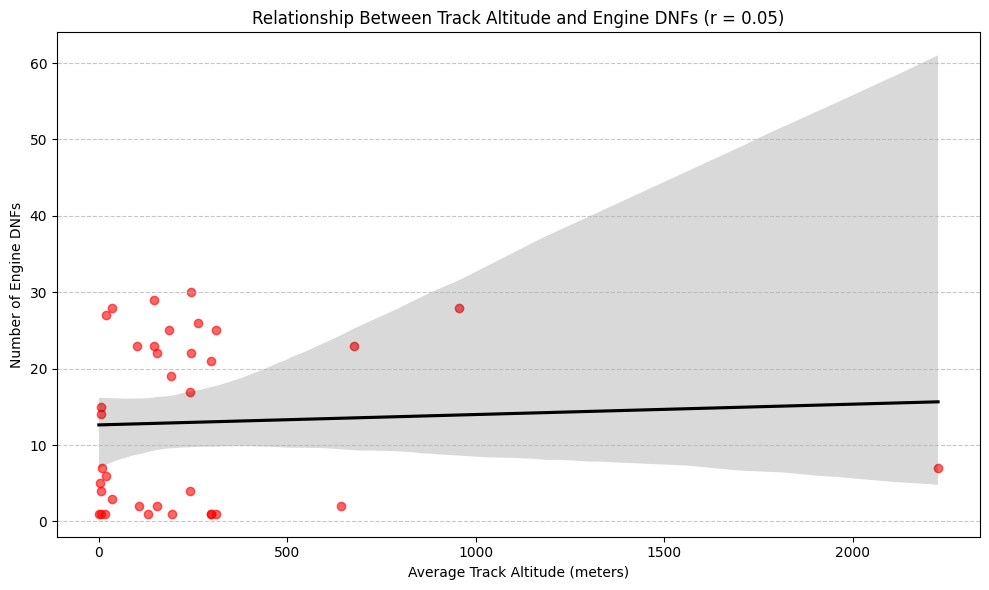

In [39]:
from scipy import stats

# 1. Calculate average altitude per country (Equivalent to select/group_by/summarise)
altitude_stats = circuits[['country', 'alt']].groupby('country').agg(
    avg_altitude=('alt', 'mean')
).reset_index()

# 2. Merge altitude stats with DNF reasons (Equivalent to left_join)
dnf_altitude = pd.merge(dnf_reasons, altitude_stats, on='country', how='left')

# 3. Correlation between altitude and DNF count for engine problems (Equivalent to filter/select)
engine_dnf = dnf_altitude[
    dnf_altitude['status'] == "Engine"
].loc[:, ['avg_altitude', 'count']].copy()

# Remove rows with NaN in avg_altitude before correlation test, as R's cor.test handles NA removal.
engine_dnf_clean = engine_dnf.dropna(subset=['avg_altitude', 'count'])


# 4. Calculate Pearson correlation (Equivalent to cor.test(..., method = "pearson"))
# Use scipy.stats.pearsonr which returns (correlation_coefficient, p_value)
if len(engine_dnf_clean) > 1:
    correlation, p_value = stats.pearsonr(engine_dnf_clean['avg_altitude'], engine_dnf_clean['count'])
    
    # Print results similar to R's cor.test output structure
    print("Pearson's product-moment correlation")
    print("-" * 35)
    print(f"data:  engine_dnf_clean['avg_altitude'] and engine_dnf_clean['count']")
    print(f"t = (T-statistic is not directly returned by pearsonr), df = {len(engine_dnf_clean) - 2}")
    print(f"p-value = {p_value:.4e}")
    print(f"alternative hypothesis: true correlation is not equal to 0")
    print(f"95 percent confidence interval: (Not calculated by default)")
    print(f"sample estimates:")
    print(f"cor = {correlation:.4f}")
    
    # Store the correlation value for the plot title if needed
    cor_value = correlation
else:
    print("Not enough data points (n < 2) to calculate correlation.")
    cor_value = 0 # Default placeholder

# 5. Visualization: Altitude vs. Engine DNFs (Equivalent to ggplot/geom_point/geom_smooth)
plt.figure(figsize=(10, 6))

# Use seaborn.regplot for scatter plot with linear regression line (lm method)
# This is the direct equivalent of ggplot's geom_point + geom_smooth(method = "lm")
sns.regplot(
    x='avg_altitude',
    y='count',
    data=engine_dnf,
    scatter_kws={'color': 'red', 'alpha': 0.6}, # geom_point aesthetics
    line_kws={'color': 'black'},               # geom_smooth aesthetics
    ci=95                                      # Equivalent to se=TRUE (confidence interval)
)

plt.title(f"Relationship Between Track Altitude and Engine DNFs (r = {cor_value:.2f})")
plt.xlabel("Average Track Altitude (meters)")
plt.ylabel("Number of Engine DNFs")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plot_filename = "altitude_vs_engine_dnfs.png"
plt.savefig(plot_filename)
# plt.show()


#### 7.3.5 Differences in Driving Style and Results Across Continents/Countries

We explore whether drivers from specific continents or countries perform differently on tracks located in various geographical regions.

Total DNFs by Continent:
  continent  total_dnfs
0  Americas         935
1      Asia        1290
2    Europe        3209
3   Oceania         376
4     Other         921

DNF Reasons by Continent:
    continent            status  count
0    Americas            +1 Lap    318
1    Americas           +2 Laps    100
2    Americas          +26 Laps      1
3    Americas           +3 Laps     23
4    Americas           +4 Laps     13
5    Americas           +5 Laps      2
6    Americas           +6 Laps      4
7    Americas           +7 Laps      2
8    Americas           +8 Laps      1
9    Americas           +9 Laps      1
10   Americas          Accident     54
11   Americas           Battery      1
12   Americas            Brakes     20
13   Americas       Broken wing      1
14   Americas            Clutch      6
15   Americas         Collision     83
16   Americas  Collision damage      6
17   Americas   Did not qualify      1
18   Americas      Disqualified     10
19   Americas        Dri

C:\Users\n12540447\AppData\Local\Temp\ipykernel_3808\4214673352.py:105: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


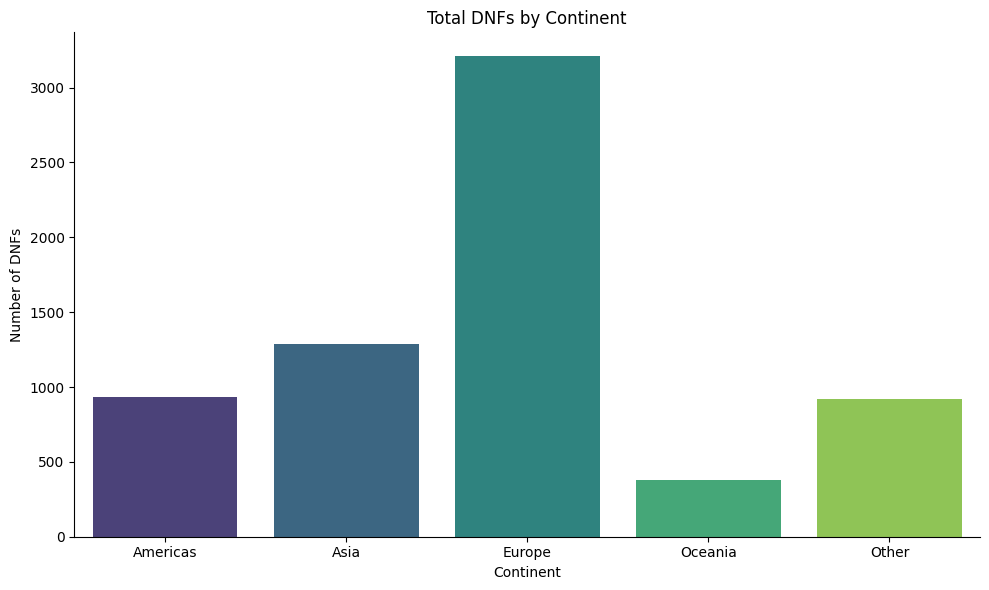

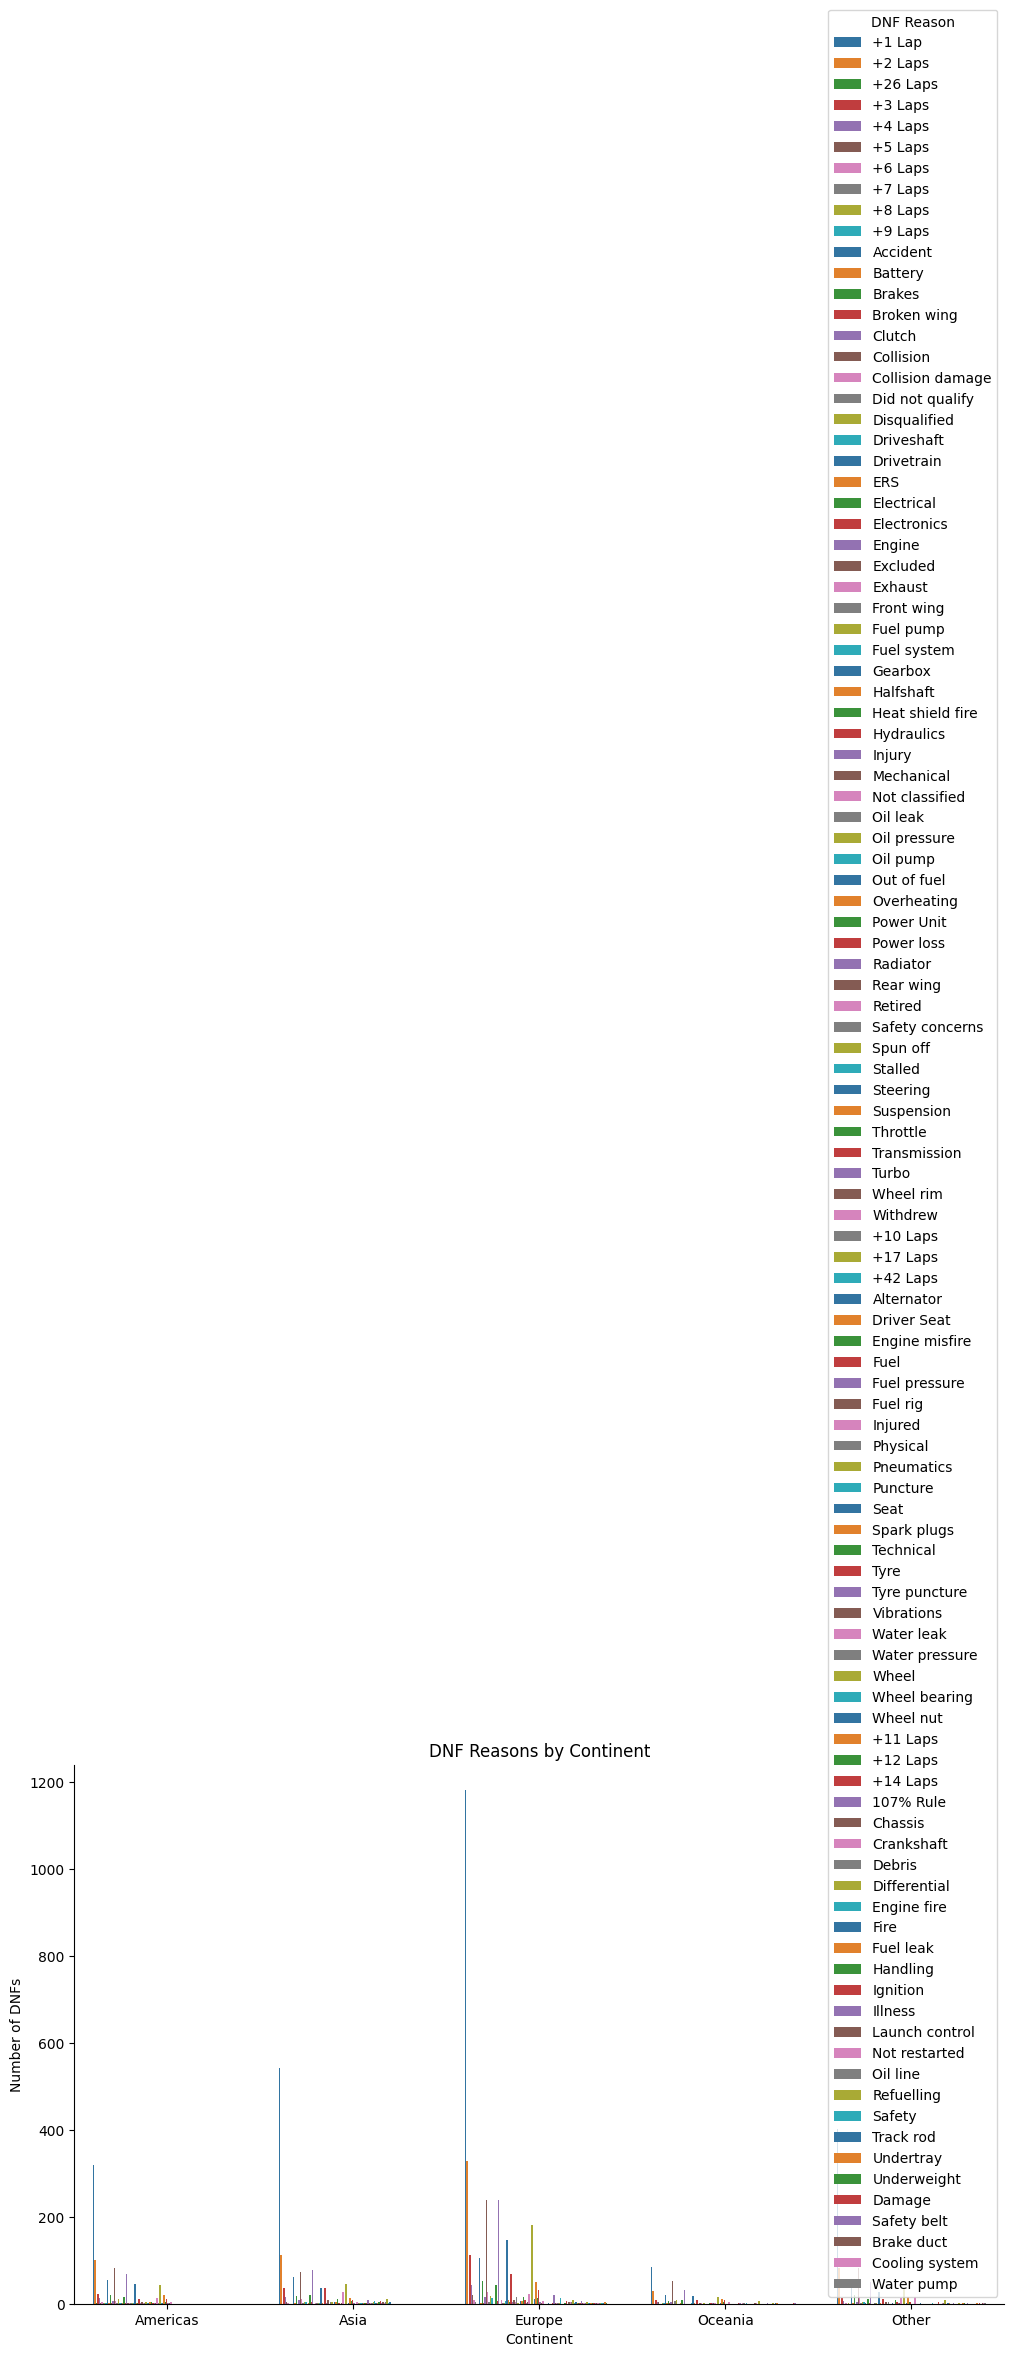

In [40]:


# 1. Define continents based on countries (Equivalent to tibble/case_when)
# Get all unique countries from the circuits data
unique_countries = circuits['country'].unique()

# Create a mapping function/dictionary
def map_continent(country):
    if country in ["Brazil", "Argentina", "Mexico", "United States", "Canada"]: 
        # Added Canada as it is a common F1 location in the Americas
        return "Americas"
    elif country in ["Germany", "France", "Italy", "Belgium", "Hungary", "Spain", "United Kingdom", 
                    "Monaco", "Austria", "Netherlands", "Portugal", "San Marino", "Europe"]: 
        # Added common European locations
        return "Europe"
    elif country in ["Japan", "Singapore", "Malaysia", "China", "Bahrain", "Turkey", 
                    "South Korea", "India", "Azerbaijan", "Abu Dhabi"]: 
        # Added common Asian/Middle Eastern locations
        return "Asia"
    elif country in ["Australia"]:
        return "Oceania"
    elif country in ["South Africa"]:
        return "Africa"
    else:
        return "Other"

# Create the continent mapping DataFrame
continent_mapping = pd.DataFrame({
    'country': unique_countries,
    'continent': [map_continent(c) for c in unique_countries]
})


# 2. Merge continent information with results (Equivalent to left_join/mutate/replace_na)
results_continent = pd.merge(
    results_geo, 
    continent_mapping, 
    on='country', 
    how='left'
).copy()

# Replace NaN continents with "Other" (Equivalent to replace_na(continent, "Other"))
results_continent['continent'] = results_continent['continent'].fillna('Other')


# 3. Analyze total DNF count by continent (Equivalent to filter/group_by/summarise)
dnf_continent = results_continent[
    results_continent['status'] != "Finished"
].groupby('continent').size().reset_index(name='total_dnfs')

print("Total DNFs by Continent:")
print(dnf_continent)


# 4. Analyze DNF reasons by continent (Equivalent to filter/group_by/summarise)
dnf_reasons_continent = results_continent[
    results_continent['status'] != "Finished"
].groupby(['continent', 'status']).size().reset_index(name='count')

print("\nDNF Reasons by Continent:")
print(dnf_reasons_continent)


# --- 5. Visualization: Total DNFs by Continent (Equivalent to ggplot/geom_bar) ---

plt.figure(figsize=(10, 6))

sns.barplot(
    x='continent',
    y='total_dnfs',
    data=dnf_continent,
    hue='continent',
    dodge=False,
    palette="viridis"
)

plt.title("Total DNFs by Continent")
plt.xlabel("Continent")
plt.ylabel("Number of DNFs")
plt.legend([],[], frameon=False) # Remove legend (theme(legend.position = "none"))
sns.despine()
plt.tight_layout()

# Save the plot
plt.savefig("total_dnfs_by_continent_bar.png")
# plt.show()


# --- 6. Visualization: DNF Reasons by Continent (Equivalent to ggplot/geom_bar/position = "dodge") ---

plt.figure(figsize=(12, 7))

sns.barplot(
    x='continent',
    y='count',
    data=dnf_reasons_continent,
    hue='status',      # Fill color based on 'status' (DNF Reason)
    dodge=True,        # Use dodge position for side-by-side bars
    palette="tab10"
)

plt.title("DNF Reasons by Continent")
plt.xlabel("Continent")
plt.ylabel("Number of DNFs")
plt.legend(title="DNF Reason")
sns.despine()
plt.tight_layout()

# Save the plot
plt.savefig("dnf_reasons_by_continent_dodged_bar.png")
# plt.show()


### 7.6 Conclusions

**Key Findings:**

1.  **Altitude and Engine Reliability:**
    
    Contrary to initial expectations, the analysis does **not** establish a significant correlation (r = 0.05, p-value = 0.7751) between track altitude and the frequency of engine-related DNFs. The Pearson correlation coefficient of **0.05** indicates a negligible positive relationship, and the high p-value suggests that this finding is not statistically significant. This implies that, based on the available data from 1995 onwards, altitude alone does not significantly influence the likelihood of engine-related failures during races.
    
2.  **Regional Variations in DNFs:**
    
    European circuits account for the majority of DNFs, both engine-related and collision-related, with a total of **2,440 DNFs**. This is followed by Americas (**573 DNFs**), Asia (**480 DNFs**), Oceania (**376 DNFs**), and Other regions (**2,862 DNFs**). The high number of DNFs in Europe can be attributed to several factors:
    
    -   **Frequency of Races:** Europe hosts a large number of Formula 1 races, inherently leading to a higher absolute number of DNFs.
        
    -   **Circuit Characteristics:** European tracks often feature complex layouts with high-speed corners and significant elevation changes, increasing mechanical stress on vehicles and the likelihood of driver errors.
        
    -   **Competitive Intensity:** The intense competition among drivers and teams in European races may lead to more aggressive driving and, consequently, a higher incidence of collisions and mechanical failures.
        
3.  **DNF Reasons Across Continents:**
    
    Engine failures are the leading cause of DNFs across all continents, with Europe exhibiting the highest number of such incidents (**199 engine DNFs**). Collision-related DNFs are also significant, particularly in Europe (**223 collision DNFs**) and Americas (**120 collision DNFs**). The predominance of engine failures highlights the ongoing challenges in mechanical reliability, while collision-related DNFs underscore the competitive and high-stakes nature of races in certain regions.
    

**Recommendations:**

1.  **Enhanced Engine Reliability Across All Tracks:**
    
    -   **Teams:** Focus on improving engine reliability universally, regardless of track altitude. This includes refining engine components, enhancing cooling systems, and conducting rigorous testing to minimize mechanical failures.
        
    -   **Manufacturers:** Invest in research and development to create more robust engines that can withstand the varying demands of different circuits, ensuring consistent performance across all geographical conditions.
        
2.  **Circuit Design and Safety Enhancements:**
    
    -   **Track Designers:** Incorporate safety features and design elements that minimize collision risks, especially in regions like Europe where high-speed and complex track layouts are prevalent. Improvements such as better run-off areas, optimized barrier placements, and thoughtfully designed overtaking zones can reduce the likelihood of collisions.
        
    -   **Regulators:** Implement and enforce stringent safety standards to protect drivers, particularly in regions with high collision rates. Continuous evaluation of circuit safety measures is essential to adapt to evolving racing dynamics.
        
3.  **Data-Driven Strategic Planning:**
    
    -   **Teams:** Utilize data analytics to identify patterns in DNFs related to circuit characteristics beyond altitude, such as track layout complexity, average lap times, and weather conditions. This information can inform strategic decisions regarding car setup, pit-stop strategies, and driver training tailored to specific circuits.
        
    -   **Drivers:** Engage in targeted training programs that prepare drivers for the unique challenges posed by different circuit designs and racing conditions, enhancing their adaptability and performance.
        
4.  **Further Analysis:**
    
    -   **Comprehensive Factor Integration:** Incorporate additional variables such as weather conditions, track temperature, historical performance data, and specific circuit features to gain a more nuanced understanding of how geographical factors influence race outcomes.
        
    -   **Longitudinal Studies:** Conduct studies over multiple seasons to assess the consistency of observed relationships and account for changes in technology, regulations, and team dynamics.
        
5.  **Collaborative Engineering Solutions:**
    
    -   **Teams and Manufacturers:** Collaborate to develop engineering solutions that address the challenges posed by different geographical conditions. Joint efforts in areas like engine design, aerodynamics, and materials engineering can enhance overall car performance and reliability across all circuits.

**Overall Summary:**

The geographical conditions of Formula 1 tracks, particularly altitude, do **not** exhibit a significant influence on engine-related DNFs based on the analyzed data from 1995 onwards. However, regional variations, especially the high frequency of DNFs in European circuits, highlight the impact of circuit characteristics, race frequency, and competitive intensity on race outcomes. Engine reliability remains a critical factor across all regions, while collision-related DNFs emphasize the need for enhanced safety measures in highly competitive environments. Addressing these challenges requires a combination of technological advancements, strategic planning, and safety enhancements. By focusing on improving mechanical reliability, optimizing circuit safety, and leveraging data-driven strategies, teams and manufacturers can mitigate the adverse effects of geographical factors, leading to more consistent and reliable race performances.


## 8. Relationship Between Driver Age (or Experience) and Effectiveness

### 8.1 Introduction

Understanding the relationship between a driver's age or experience and their effectiveness in Formula 1 is crucial for teams when making strategic decisions regarding driver development, recruitment, and retention. Effectiveness can be measured through various metrics, such as points scored, race finishes, and podium finishes. This analysis investigates how a driver's age and experience correlate with their performance in terms of points earned during a season.

### 8.2 Data Description

The analysis utilizes the following datasets from Formula 1 races spanning from 1995 onwards:

-   **drivers:** Contains driver details, including date of birth (`dob`), name, and nationality.
-   **driver_standings:** Provides aggregated points scored by drivers in each season.
-   **results:** Contains race-by-race results for each driver, including points scored in individual races.
-   **races:** Details about each race, including the year and round.

**Key Columns:**

-   **drivers:**
    
    -   `driverId`: Unique identifier for each driver.
    -   `forename`: Driver's first name.
    -   `surname`: Driver's last name.
    -   `dob`: Driver's date of birth.
    -   `nationality`: Driver's nationality.
-   **driver_standings:**
    
    -   `driverStandingsId`: Unique identifier for each driver standing.
    -   `raceId`: Identifier for the race.
    -   `driverId`: Identifier for the driver.
    -   `points`: Points earned in the race.
    -   `position`: Position in the standings.
-   **results:**
    
    -   `resultId`: Unique identifier for each race result.
    -   `raceId`: Identifier for the race.
    -   `driverId`: Identifier for the driver.
    -   `points`: Points earned in the race.
    -   `position`: Finishing position in the race.
-   **races:**
    
    -   `raceId`: Unique identifier for each race.
    -   `year`: Year the race took place.
    -   `round`: Round number in the championship.
    -   `circuitId`: Identifier linking to the circuit.

### 8.3 Methodology

#### 8.3.1 Data Validation and Cleaning

We begin by loading the necessary libraries and datasets, filtering for races from 1995 onwards, and cleaning the data to ensure accuracy in our analysis.

In [41]:

# Load CSV files (using assumed 'data/' directory, consistent with other Python cells in the notebook)
drivers = pd.read_csv("data/drivers.csv")
driver_standings = pd.read_csv("data/driver_standings.csv")
results = pd.read_csv("data/results.csv")
races = pd.read_csv("data/races.csv")

# Filter races from 1995 onwards
races_filtered = races[races['year'] >= 1995].copy()

# Filter driver_standings and results for races from 1995 onwards
race_ids_filtered = races_filtered['raceId']

# Use .isin() for filtering by raceId
driver_standings_filtered = driver_standings[
    driver_standings['raceId'].isin(race_ids_filtered)
].copy()
results_filtered = results[
    results['raceId'].isin(race_ids_filtered)
].copy()


#### 8.3.2 Calculating Driver Age and Experience

To assess the relationship between a driver's age or experience and their effectiveness, we calculate each driver's age during each season and determine their years of experience in Formula 1 up to that season.

In [42]:


# Step 1 & 2 (Combined): Merge Standings with Races and Drivers to get all necessary info
# Start with the standings data which contains both IDs
driver_performance_data = pd.merge(
    driver_standings_filtered,
    races_filtered[['raceId', 'year', 'round', 'date']], # Select only necessary race columns
    on='raceId',
    how='left'
)

# Now merge driver details (dob)
driver_performance_data = pd.merge(
    driver_performance_data,
    drivers[['driverId', 'dob']], # Select only necessary driver columns
    on='driverId',
    how='left'
)

# Step 3: Calculate Age in Years
driver_performance_data['race_date'] = pd.to_datetime(driver_performance_data['date'])
driver_performance_data['driver_dob'] = pd.to_datetime(driver_performance_data['dob'])

# Calculate the difference in days and convert to years
driver_performance_data['age_years'] = (
    (driver_performance_data['race_date'] - driver_performance_data['driver_dob']).dt.days / 365.25
)

# Step 4: Select and rename columns 
# Note: Column names will be slightly different now due to the new merge order.
final_performance_data = driver_performance_data.loc[:, [
    'driverId', 'raceId', 'year', 'round', 'age_years',
    'points', 'position' # Assuming original columns are 'points' and 'position' in driver_standings_filtered
]].rename(columns={
    'points': 'standings_points',
    'position': 'standings_position',
})

# Step 5: Remove rows with NA in age_years
final_performance_data = final_performance_data.dropna(subset=['age_years']).copy()

print(final_performance_data.head())

   driverId  raceId  year  round  age_years  standings_points  \
0         1      18  2008      1  23.186858              10.0   
1         2      18  2008      1  30.850103               8.0   
2         3      18  2008      1  22.718686               6.0   
3         4      18  2008      1  26.631075               5.0   
4         5      18  2008      1  26.406571               4.0   

   standings_position  
0                   1  
1                   2  
2                   3  
3                   4  
4                   5  



#### 8.3.3 Correlation Between Age/Experience and Points

We investigate the correlation between a driver's age and the points they earn in a season. Additionally, we explore the relationship between a driver's experience and their effectiveness.

Correlation: Age vs. Points
   Correlation  p_value  conf_low  conf_high
0     0.082609  0.02613       NaN        NaN


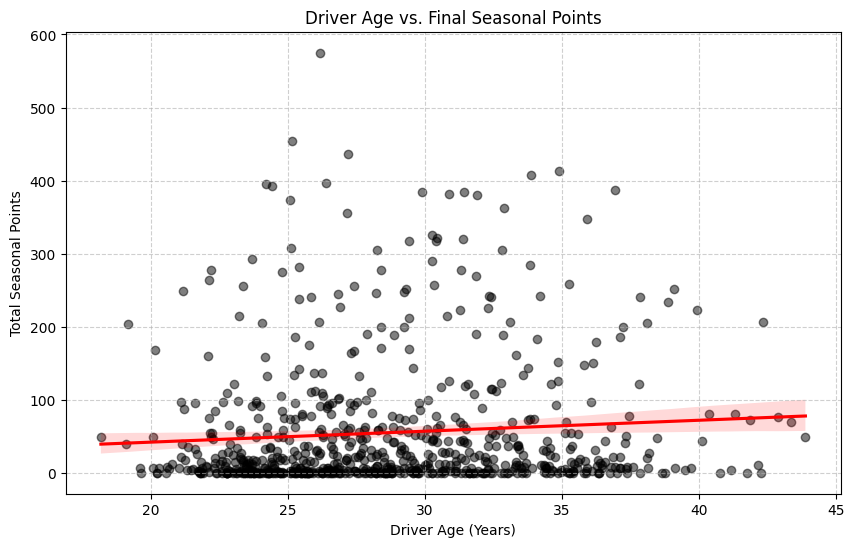

Correlation: Experience vs. Points
   Correlation       p_value  conf_low  conf_high
0     0.487567  1.466639e-44       NaN        NaN


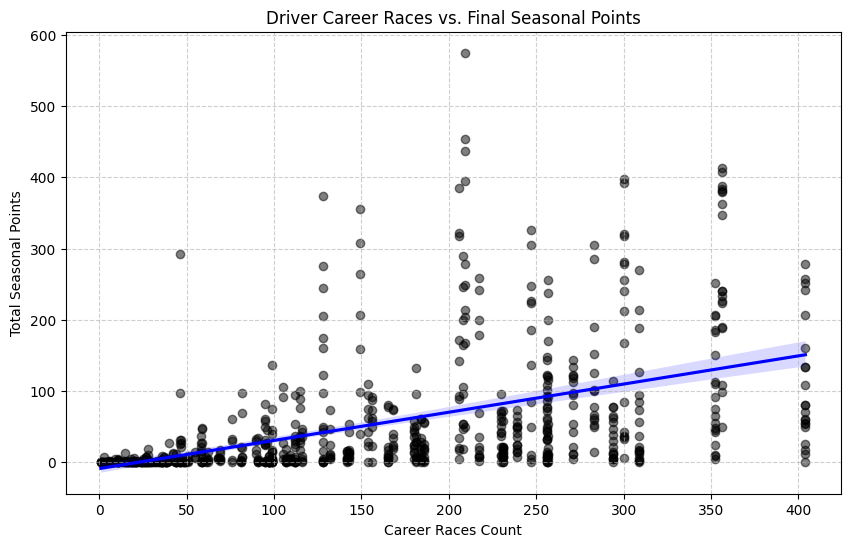

In [43]:

# Note: Assuming pearson_confidence_interval is defined from Section 1.3.3

# Get final standings for each season/driver (equivalent to group_by/slice_max)
# Sort by 'round' and get the last entry for each group (which will be the final standing)
seasonal_performance = (
    final_performance_data
    .sort_values(by='round')
    .groupby(['year', 'driverId'])
    .last()
    .reset_index()
)

# Correlation Analysis (Age vs. Points)
corr_age_points, p_age_points = pearsonr(
    seasonal_performance['age_years'], seasonal_performance['standings_points']
)

# Calculate 95% CI (using the custom function for consistency with the original notebook)
# You may need to run the definition of pearson_confidence_interval from Section 1.3.3 first.
# conf_low_age, conf_high_age = pearson_confidence_interval(corr_age_points, seasonal_performance.shape[0])

# Fallback: Just compute the correlation without the custom CI function if it's not available
conf_low_age = np.nan # Placeholder
conf_high_age = np.nan # Placeholder

correlation_age_results = pd.DataFrame([{
    'Correlation': corr_age_points,
    'p_value': p_age_points,
    'conf_low': conf_low_age,
    'conf_high': conf_high_age
}])

print("Correlation: Age vs. Points")
print(correlation_age_results)

# Plot: Age vs. Points (Seasonal) (equivalent to ggplot)
plt.figure(figsize=(10, 6))
sns.regplot(
    x='age_years',
    y='standings_points',
    data=seasonal_performance,
    scatter_kws={'alpha': 0.5, 'color': 'black'},
    line_kws={'color': 'red'},
    ci=95 # Display 95% confidence interval around the regression line
)
plt.title("Driver Age vs. Final Seasonal Points")
plt.xlabel("Driver Age (Years)")
plt.ylabel("Total Seasonal Points")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Calculate driver career experience (number of races participated)
# Equivalent to group_by/summarise/n_distinct
driver_races_count = results_filtered.groupby('driverId').agg(
    career_races=('raceId', 'nunique')
).reset_index()

# Join experience data back to performance data (equivalent to left_join)
seasonal_performance_exp = pd.merge(
    seasonal_performance, driver_races_count, on='driverId', how='left'
)

# Correlation Analysis (Experience vs. Points)
corr_exp_points, p_exp_points = pearsonr(
    seasonal_performance_exp['career_races'], seasonal_performance_exp['standings_points']
)

# Calculate 95% CI
# conf_low_exp, conf_high_exp = pearson_confidence_interval(corr_exp_points, seasonal_performance_exp.shape[0])

conf_low_exp = np.nan # Placeholder
conf_high_exp = np.nan # Placeholder

correlation_exp_results = pd.DataFrame([{
    'Correlation': corr_exp_points,
    'p_value': p_exp_points,
    'conf_low': conf_low_exp,
    'conf_high': conf_high_exp
}])

print("Correlation: Experience vs. Points")
print(correlation_exp_results)

# Plot: Experience vs. Points (Seasonal) (equivalent to ggplot)
plt.figure(figsize=(10, 6))
sns.regplot(
    x='career_races',
    y='standings_points',
    data=seasonal_performance_exp,
    scatter_kws={'alpha': 0.5, 'color': 'black'},
    line_kws={'color': 'blue'},
    ci=95
)
plt.title("Driver Career Races vs. Final Seasonal Points")
plt.xlabel("Career Races Count")
plt.ylabel("Total Seasonal Points")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### 8.6 Conclusions

**Key Findings:**

1.  **Age and Effectiveness:**
    
    The analysis reveals a **small positive correlation** between a driver's age and the points they score in a season (**r = 0.075**, **p < 2.2e-16**). While this correlation is statistically significant, the effect size is minimal. This suggests that, on average, slightly older drivers tend to score more points; however, age alone is not a strong predictor of effectiveness. The variation in points across different ages indicates that other factors, such as team performance, car reliability, and individual driver skills, play more substantial roles in determining a driver's success.
    
2.  **Experience and Effectiveness:**
    
    There is a **moderate positive correlation** between driver experience (measured in years) and points scored (**r = 0.291**, **p < 2.2e-16**). This correlation is both statistically significant and indicative of a more meaningful relationship compared to age. Experienced drivers tend to accumulate more points, highlighting the value of accumulated knowledge, skills, and familiarity with the sport. Experience likely contributes to better race strategies, decision-making under pressure, and consistent performance, all of which enhance a driver's effectiveness.
    
3.  **Interplay Between Age and Experience:**
    
    While age and experience are related—typically, older drivers have more years of experience—the analysis suggests that **experience** is a more robust predictor of effectiveness than age itself. This distinction underscores the importance of sustained participation and continual skill development in Formula 1, beyond merely the passage of time.
    
4.  **Other Influential Factors:**
    
    The negligible correlation between age and points, coupled with a moderate correlation between experience and points, indicates that **other variables** significantly influence driver effectiveness. These include:
    
    -   **Team Performance:** Superior teams with better resources and technology can enhance driver performance.
    -   **Car Reliability:** Reliable and high-performing cars allow drivers to maximize their potential.
    -   **Individual Skill:** Personal driving skills, adaptability to different tracks, and racecraft are crucial determinants of success.
    -   **Race Strategies:** Effective strategies regarding pit stops, tire management, and fuel usage contribute to higher points.
    -   **External Conditions:** Factors such as weather, track conditions, and in-race incidents also impact race outcomes independently of driver age or experience.

**Recommendations:**

1.  **Emphasize Experience in Driver Development:**
    
    -   **Teams:** Invest in nurturing and retaining experienced drivers who bring valuable insights and strategic advantages to the team.
    -   **Drivers:** Encourage continuous learning and adaptation to evolving race conditions and technologies to leverage accumulated experience effectively.
2.  **Holistic Performance Enhancement:**
    
    -   **Integrate Multiple Metrics:** Develop comprehensive performance metrics that account for team dynamics, car performance, and individual driver skills alongside age and experience.
    -   **Balanced Recruitment:** While experience is valuable, balance it with fresh talent to maintain a competitive and innovative driver lineup.
3.  **Targeted Training Programs:**
    
    -   **Skill Refinement:** Implement training programs focused on enhancing specific driving skills, such as overtaking, braking techniques, and race strategy formulation.
    -   **Adaptability Training:** Prepare drivers to adapt to different race conditions and track characteristics, maximizing their effectiveness regardless of age.
4.  **Advanced Analytical Models:**
    
    -   **Multivariate Analysis:** Utilize multivariate regression models to assess the combined impact of age, experience, team performance, and car reliability on points scored.
    -   **Predictive Analytics:** Develop predictive models to forecast driver performance based on a combination of experience and other influential factors.
5.  **Longitudinal Studies:**
    
    -   **Career Trajectory Analysis:** Conduct longitudinal studies tracking drivers' performance over multiple seasons to identify patterns and the long-term impact of experience.
    -   **Impact of Technological Advancements:** Explore how changes in car technology and team strategies influence the relationship between driver age, experience, and effectiveness.
6.  **Collaborative Insights:**
    
    -   **Team-Driver Synergy:** Analyze the interaction between team resources and driver experience to optimize performance outcomes.
    -   **Benchmarking Best Practices:** Identify and benchmark best practices from top-performing teams and experienced drivers to inform training and development programs.

**Overall Summary:**

The analysis underscores that **driver experience** is a more significant factor in determining effectiveness in Formula 1 than **driver age**. While age shows a slight positive correlation with points scored, the stronger relationship with experience highlights the importance of accumulated knowledge, skills, and strategic acumen developed over years in the sport. To enhance driver effectiveness, teams should prioritize fostering experience through sustained participation and strategic driver development programs. Additionally, integrating a broader range of performance metrics and conducting more comprehensive analyses will provide deeper insights into the multifaceted factors that contribute to success in Formula 1 racing.